In [1]:
# Standard definitions needed for script
import numpy as np
import matplotlib.pyplot as plt
import numpy.ma as ma
import math
from astropy.table import Table
from astropy.io import fits
import astropy.units as u
from astropy.coordinates.sky_coordinate import SkyCoord
from astropy.units import Quantity
from numpy.polynomial.polynomial import polyfit
import astropy.constants as const
from astropy.coordinates import Angle
import pickle
import pandas as pd
from matplotlib.patches import Rectangle
from sklearn.cluster import KMeans
import scipy
%matplotlib inline

# Read in Data and Cross Match

In [98]:
file = 'Data/GAIA_data2.pkl'
with open(file,'rb') as f: 
    data = pickle.load(f)
GTab = data['GTab']

print (GTab.colnames)
Gra = GTab["ra"]
Gdec = GTab["dec"]
Gpmra = GTab["pmra"]
Gpmra_e = GTab["pmra_error"]
Gpmdec = GTab["pmdec"]
Gpmdec_e = GTab["pmdec_error"]
Gpar = GTab["parallax"]
Gpar_e = GTab['parallax_error']
Gpar_sn = GTab["parallax_over_error"]
Gsepar = GTab["angular_distance"]
G2MASS = GTab["designation_2"]
g = GTab["phot_g_mean_mag"]
b = GTab["phot_bp_mean_mag"]
r = GTab["phot_rp_mean_mag"]
J = GTab["j_m"]
H = GTab["h_m"]
K = GTab["ks_m"]
print(" GAIA Table contains ",len(Gra)," sources")

#calculate distance in pc and proper motion in km/s
Gdist = 1000./Gpar
Gpmra_km = ((Gpmra*Gdist*const.au.value)/(u.yr.to('s')*1000.))/1000.
Gpmdec_km = ((Gpmdec*Gdist*const.au.value)/(u.yr.to('s')*1000.))/1000.

Gpmra_km_e = ((Gpmra_e*Gdist*const.au.value)/(u.yr.to('s')*1000.))/1000.
Gpmdec_km_e = ((Gpmdec_e*Gdist*const.au.value)/(u.yr.to('s')*1000.))/1000.


#add variables to an array
Gvalues = {'ra':Gra,'dec':Gdec,'pmra':Gpmra,'pmra_error':Gpmra_e,'pmdec':Gpmdec,'pmdec_error':Gpmdec_e,\
           'parallax':Gpar,'parallax_error':Gpar_e,'par_over_e':Gpar_sn,'Dist':Gdist,'pmra_km':Gpmra_km,
           'pmdec_km':Gpmdec_km,'pmra_km_e':Gpmra_km_e,'pmdec_km_e':Gpmdec_km_e}

['solution_id', 'designation', 'source_id', 'random_index', 'ref_epoch', 'ra', 'ra_error', 'dec', 'dec_error', 'parallax', 'parallax_error', 'parallax_over_error', 'pmra', 'pmra_error', 'pmdec', 'pmdec_error', 'ra_dec_corr', 'ra_parallax_corr', 'ra_pmra_corr', 'ra_pmdec_corr', 'dec_parallax_corr', 'dec_pmra_corr', 'dec_pmdec_corr', 'parallax_pmra_corr', 'parallax_pmdec_corr', 'pmra_pmdec_corr', 'astrometric_n_obs_al', 'astrometric_n_obs_ac', 'astrometric_n_good_obs_al', 'astrometric_n_bad_obs_al', 'astrometric_gof_al', 'astrometric_chi2_al', 'astrometric_excess_noise', 'astrometric_excess_noise_sig', 'astrometric_params_solved', 'astrometric_primary_flag', 'astrometric_weight_al', 'astrometric_pseudo_colour', 'astrometric_pseudo_colour_error', 'mean_varpi_factor_al', 'astrometric_matched_observations', 'visibility_periods_used', 'astrometric_sigma5d_max', 'frame_rotator_object_type', 'matched_observations', 'duplicated_source', 'phot_g_n_obs', 'phot_g_mean_flux', 'phot_g_mean_flux_erro

In [3]:
#creates list of indentifiers from 2MASS? 

gaia_list = []
for i in range(0,len(G2MASS)):
    gaia_list.append(G2MASS[i].decode('utf-8'))

In [4]:
#read in gould belt YSO catalog

infile = "Data/SERAQU-YSOs.tbl"
GBYSO = Table.read(infile,format="ascii.ipac")
print(GBYSO.colnames)
GBYSOra = GBYSO["ra"]
GBYSOdec = GBYSO["dec"]
GBYSO2MASS = GBYSO["id2mass"]
print("Read ",len(GBYSOra)," YSOs from GB YSO catalog")

#match up GAIA catalog and Gould Belt YSO
GBYSO_match = np.empty(len(GBYSO2MASS),dtype=int); GBYSO_match.fill(-2)
for j in range(0,len(GBYSO2MASS)):
    if(GBYSO2MASS[j] in gaia_list):
        GBYSO_match[j] = gaia_list.index(GBYSO2MASS[j])
    else:
        GBYSO_match[j] = -2
good_GBYSO = GBYSO_match > -1
print(len(GBYSO_match[good_GBYSO]))
print(np.where(GBYSO_match > -1))

['GBS_ID', 'ra', 'D_ra', 'dec', 'D_dec', 'Q_pos', 'Q_merge', 'id2mass', 'Prob_Galc', 'alpha', 'D_alpha', 'alpha_chi2', 'alpha_nfit', 'object_type', 'Av', 'D_Av', 'mag_IR1', 'D_mag_IR1', 'Av_chi2', 'Av_nfit', 'J_flux_c', 'J_D_flux_c', 'J_date_c', 'J_Q_det_c', 'H_flux_c', 'H_D_flux_c', 'H_date_c', 'H_Q_det_c', 'Ks_flux_c', 'Ks_D_flux_c', 'Ks_date_c', 'Ks_Q_det_c', 'IR1_flux_1', 'IR1_D_flux_1', 'IR1_date_1', 'IR1_Q_det_1', 'IR1_flux_2', 'IR1_D_flux_2', 'IR1_date_2', 'IR1_Q_det_2', 'IR1_flux_c', 'IR1_D_flux_c', 'IR1_date_c', 'IR1_Q_det_c', 'IR1_Q_flux_m', 'IR1_imtype', 'IR1_src_area', 'IR1_amajor', 'IR1_aminor', 'IR1_tilt', 'IR2_flux_1', 'IR2_D_flux_1', 'IR2_date_1', 'IR2_Q_det_1', 'IR2_flux_2', 'IR2_D_flux_2', 'IR2_date_2', 'IR2_Q_det_2', 'IR2_flux_c', 'IR2_D_flux_c', 'IR2_date_c', 'IR2_Q_det_c', 'IR2_Q_flux_m', 'IR2_imtype', 'IR2_src_area', 'IR2_amajor', 'IR2_aminor', 'IR2_tilt', 'IR3_flux_1', 'IR3_D_flux_1', 'IR3_date_1', 'IR3_Q_det_1', 'IR3_flux_2', 'IR3_D_flux_2', 'IR3_date_2', 'IR3_Q

In [5]:
#read in gould belt stars + dust catalgog

infile = "Data/SERP_GB_star+dust.tbl"
GBSD = Table.read(infile,format="ascii.ipac")
# print(GBSD.colnames)
GBSDra = GBSD["ra"]
GBSDdec = GBSD["dec"]
GBSD2MASS = GBSD["id2mass"]
print("Read ",len(GBSDra)," YSOs from GB Star+Dust catalog")

#match up GAIA catalog and Gould Belt stars+dust
GBSD_match = np.empty(len(GBSD2MASS),dtype=int); GBSD_match.fill(-2)
for j in range(0,len(GBSD2MASS)):
    if(GBSD2MASS[j] in gaia_list):
        GBSD_match[j] = gaia_list.index(GBSD2MASS[j])
    else:
        GBSD_match[j] = -2
good_GBSD = GBSD_match > -1
print(len(GBSD_match[good_GBSD]))
print(np.where(GBSD_match > -1))

Read  3725  YSOs from GB Star+Dust catalog
97
(array([ 690,  744,  749,  850,  891,  893,  949,  989, 1170, 1185, 1213,
       1280, 1291, 1311, 1336, 1400, 1401, 1414, 1437, 1470, 1506, 1583,
       1627, 1721, 1764, 1781, 1793, 1799, 1880, 1907, 1956, 2005, 2079,
       2107, 2178, 2186, 2188, 2194, 2212, 2219, 2223, 2226, 2233, 2254,
       2304, 2330, 2572, 2615, 2642, 2751, 2752, 2859, 2902, 2920, 2956,
       3084, 3119, 3127, 3129, 3133, 3136, 3138, 3170, 3175, 3213, 3267,
       3271, 3287, 3304, 3310, 3326, 3330, 3344, 3346, 3366, 3369, 3372,
       3375, 3380, 3406, 3417, 3435, 3465, 3478, 3480, 3488, 3489, 3494,
       3501, 3512, 3521, 3530, 3542, 3549, 3625, 3697, 3719]),)


In [6]:
#read in c2d YSO catalog 

infile = "Data/catalog-SER-YSOc.tbl"
c2dYSO = Table.read(infile,format="ascii.ipac")
print(c2dYSO.colnames)
c2dYSOra = c2dYSO["ra"]
c2dYSOdec = c2dYSO["dec"]
c2dYSO2MASS = c2dYSO["id2mass"]
c2dYSOobj = c2dYSO["object_type"]
print("Read ",len(c2dYSOra)," YSOs from c2d YSO catalog")

#match up GAIA catalog and c2d YSO catalog
c2dYSO_match = np.empty(len(c2dYSO2MASS),dtype=int); c2dYSO_match.fill(-2)
for j in range(0,len(c2dYSO2MASS)):
    if(c2dYSO2MASS[j] in gaia_list):
        c2dYSO_match[j] = gaia_list.index(c2dYSO2MASS[j])
    else:
        c2dYSO_match[j] = -2
good_c2dYSO = c2dYSO_match > -1
print(len(c2dYSO_match[good_c2dYSO]))
print(np.where(c2dYSO_match > -1))

['c2d_ID', 'ra', 'D_ra', 'dec', 'D_dec', 'Q_pos', 'Q_merge', 'id2mass', 'Prob_Galc', 'alpha', 'D_alpha', 'alpha_chi2', 'alpha_nfit', 'object_type', 'Av', 'D_Av', 'mag_IR1', 'D_mag_IR1', 'Av_chi2', 'Av_nfit', 'J_flux_c', 'J_D_flux_c', 'J_date_c', 'J_Q_det_c', 'H_flux_c', 'H_D_flux_c', 'H_date_c', 'H_Q_det_c', 'Ks_flux_c', 'Ks_D_flux_c', 'Ks_date_c', 'Ks_Q_det_c', 'IR1_flux_1', 'IR1_D_flux_1', 'IR1_date_1', 'IR1_Q_det_1', 'IR1_flux_2', 'IR1_D_flux_2', 'IR1_date_2', 'IR1_Q_det_2', 'IR1_flux_c', 'IR1_D_flux_c', 'IR1_date_c', 'IR1_Q_det_c', 'IR1_Q_flux_m', 'IR1_imtype', 'IR1_src_area', 'IR1_amajor', 'IR1_aminor', 'IR1_tilt', 'IR2_flux_1', 'IR2_D_flux_1', 'IR2_date_1', 'IR2_Q_det_1', 'IR2_flux_2', 'IR2_D_flux_2', 'IR2_date_2', 'IR2_Q_det_2', 'IR2_flux_c', 'IR2_D_flux_c', 'IR2_date_c', 'IR2_Q_det_c', 'IR2_Q_flux_m', 'IR2_imtype', 'IR2_src_area', 'IR2_amajor', 'IR2_aminor', 'IR2_tilt', 'IR3_flux_1', 'IR3_D_flux_1', 'IR3_date_1', 'IR3_Q_det_1', 'IR3_flux_2', 'IR3_D_flux_2', 'IR3_date_2', 'IR3_Q

In [7]:
#read in c2d YSO stars+dust catalog

infile = "Data/SERP_c2d_star+dust.tbl"
c2dSD = Table.read(infile,format="ascii.ipac")
# print(GBSD.colnames)
c2dSDra = c2dSD["ra"]
c2dSDdec = c2dSD["dec"]
c2dSD2MASS = c2dSD["id2mass"]
print("Read ",len(c2dSDra)," YSOs from c2d Star+Dust catalog")

#match up GAIA catalog and c2d YSO catalog
c2dSD_match = np.empty(len(c2dSD2MASS),dtype=int); c2dSD_match.fill(-2)
for j in range(0,len(c2dSD2MASS)):
    if(c2dSD2MASS[j] in gaia_list):
        c2dSD_match[j] = gaia_list.index(c2dSD2MASS[j])
    else:
        c2dSD_match[j] = -2
good_c2dSD = c2dSD_match > -1
print(len(c2dSD_match[good_c2dSD]))
print(np.where(c2dSD_match > -1))

Read  256  YSOs from c2d Star+Dust catalog
24
(array([  2,  29,  51,  54, 126, 128, 142, 147, 153, 156, 171, 175, 191,
       193, 201, 214, 217, 219, 223, 224, 228, 235, 238, 251]),)


In [8]:
#get Herschel Data
#from astroquery.irsa import Irsa

#H70table = Irsa.query_region(SkyCoord(myra,mydec,unit = (u.deg,u.deg),frame='ircs'),catalog='ppsc_70',
#                            spatial='Box',width=0.4*u.deg)

# Analyze Data

In [9]:
#total number of YSO matches

#YSO matches
YSO_match = c2dYSO_match; YSO_match = np.append(YSO_match,GBYSO_match)
good_YSO = YSO_match > -1
print("Total number of GAIA matches to YSOs: ",len(YSO_match[good_YSO]))

#Star + Dust matches
SD_match = c2dSD_match; SD_match = np.append(SD_match,GBSD_match)
good_SD = SD_match > -1
print("Total number of GAIA matches to star+dust: ",len(SD_match[good_SD]))

#All YSO matches
ALL_match = YSO_match
ALL_match = np.append(ALL_match,SD_match)
good_ALL = ALL_match > -1
print("Total number of all matches: ",len(ALL_match[good_ALL]))

Total number of GAIA matches to YSOs:  195
Total number of GAIA matches to star+dust:  121
Total number of all matches:  316


In [10]:
#Coordinates that indicate regions

#region 1
ra_min1 = 279
ra_max1 = 280.1
dec_min1 = -1
dec_max1 = 1
width1 = (ra_max1-ra_min1)
height1 = (dec_max1 - dec_min1)

sky_region1 = [ra_min1,ra_max1,dec_min1,dec_max1]

#region 2
ra_min2 = 276.5
ra_max2 = 278.5
dec_min2 = -4.25
dec_max2 = -1.4
width2 = (ra_max2-ra_min2)
height2 = (dec_max2 - dec_min2)

sky_region2 = [ra_min2,ra_max2,dec_min2,dec_max2]

#upper part of region 2
dec_split2 = -3.0
ra_min2u = ra_min2
ra_max2u = ra_max2
dec_min2u = dec_split2
dec_max2u = dec_max2
width2u = (ra_max2u-ra_min2u)
height2u = (dec_max2u-dec_min2u)

sky_region2u = [ra_min2u,ra_max2u,dec_min2u,dec_max2u]

#down part of region 2
ra_min2d = ra_min2
ra_max2d = ra_max2
dec_min2d = dec_min2
dec_max2d = dec_split2
width2d = (ra_max2d-ra_min2d)
height2d = (dec_max2d-dec_min2d)

sky_region2d = [ra_min2d,ra_max2d,dec_min2d,dec_max2d]

#W40
ra_split2 = 277.45
ra_minW40 = ra_split2
ra_maxW40 = ra_max2
dec_minW40 = dec_min2u
dec_maxW40 = dec_max2u
widthW40 = (ra_maxW40-ra_minW40)
heightW40 = (dec_maxW40-dec_minW40)

sky_regionW40 = [ra_minW40,ra_maxW40,dec_minW40,dec_maxW40]
print(sky_regionW40)

#South

ra_minS = ra_min2
ra_maxS = ra_split2
dec_minS = dec_min2u
dec_maxS = dec_max2u
widthS = (ra_maxS-ra_minS)
heightS = (dec_maxS-dec_minS)

sky_regionS = [ra_minS,ra_maxS,dec_minS,dec_maxS]
print(sky_regionS)

#region 3
ra_min3 = 276.75
ra_max3 = 277.75
dec_min3 = -1
dec_max3 = 2
width3 = (ra_max3-ra_min3)
height3 = (dec_max3 - dec_min3)

sky_region3 = [ra_min3,ra_max3,dec_min3,dec_max3]

#region 3 upper
dec_split3 = 0.4
ra_min3u = ra_min3
ra_max3u = ra_max3
dec_min3u = dec_split3
dec_max3u = dec_max3
width3u = (ra_max3u-ra_min3u)
height3u = (dec_max3u - dec_min3u)

sky_region3u = [ra_min3u,ra_max3u,dec_min3u,dec_max3u]

#region 3 down
ra_min3d = ra_min3
ra_max3d = ra_max3
dec_min3d = dec_min3
dec_max3d = dec_split3
width3d = (ra_max3d-ra_min3d)
height3d = (dec_max3d - dec_min3d)

sky_region3d = [ra_min3d,ra_max3d,dec_min3d,dec_max3d]

[277.45, 278.5, -3.0, -1.4]
[276.5, 277.45, -3.0, -1.4]


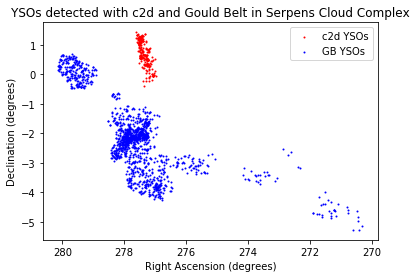

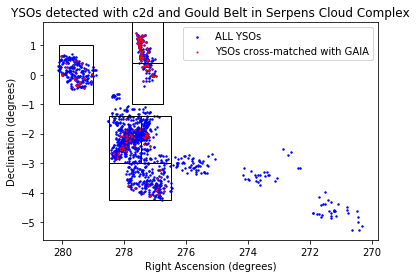

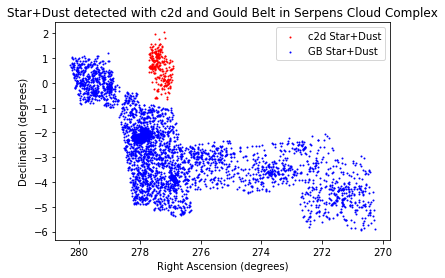

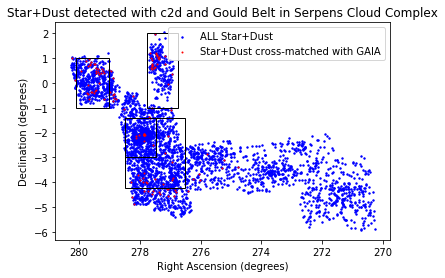

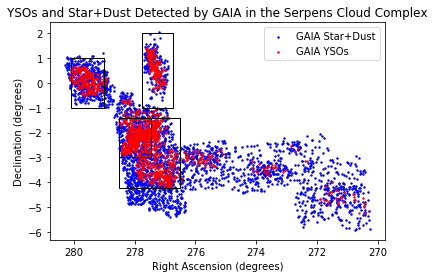

In [11]:
#combine ra and dec for all YSOs into an array for ra and an array for dec
c2dYSOra_data = np.array(c2dYSOra.data)
c2dYSOdec_data = np.array(c2dYSOdec.data)
GBYSOra_data = np.array(GBYSOra.data)
GBYSOdec_data = np.array(GBYSOdec.data)
YSO_ra = c2dYSOra_data; YSO_ra = np.append(YSO_ra,GBYSOra_data)
YSO_dec = c2dYSOdec_data; YSO_dec = np.append(YSO_dec,GBYSOdec_data)

#combine ra and dec for all star+dust into an array for ra and an array for dec
c2dSDra_data = np.array(c2dSDra.data)
c2dSDdec_data = np.array(c2dSDdec.data)
GBSDra_data = np.array(GBSDra.data)
GBSDdec_data = np.array(GBSDdec.data)
SD_ra = c2dSDra_data; SD_ra = np.append(SD_ra,GBSDra_data)
SD_dec = c2dSDdec_data; SD_dec = np.append(SD_dec,GBSDdec_data)

#combine ra and dec for all 


#Plot of c2d and Gould Belt YSOs
figure = plt.figure()
plt.scatter(c2dYSOra_data,c2dYSOdec_data,c='r',label = 'c2d YSOs',s=1)
plt.scatter(GBYSOra_data,GBYSOdec_data,c='b',label = 'GB YSOs',s=1)
plt.gca().invert_xaxis()
plt.xlabel('Right Ascension (degrees)')
plt.ylabel('Declination (degrees)')
plt.title('YSOs detected with c2d and Gould Belt in Serpens Cloud Complex')
plt.legend()
plt.show()

#Plot of matched YSOs and all YSOs
figure = plt.figure()
plt.scatter(YSO_ra,YSO_dec,c='b',s=2,label='ALL YSOs')
plt.scatter(YSO_ra[YSO_match >-1],YSO_dec[YSO_match >-1],c='r',s=1,label='YSOs cross-matched with GAIA')
plt.xlabel('Right Ascension (degrees)')
plt.ylabel('Declination (degrees)')
plt.title('YSOs detected with c2d and Gould Belt in Serpens Cloud Complex')
plt.legend()
plt.gca().add_patch(Rectangle((ra_min1,dec_min1),width1,height1,fill=False))
plt.gca().add_patch(Rectangle((ra_minW40,dec_minW40),widthW40,heightW40,fill=False))
plt.gca().add_patch(Rectangle((ra_minS,dec_minS),widthS,heightS,fill=False))
plt.gca().add_patch(Rectangle((ra_min2d,dec_min2d),width2d,height2d,fill=False))
plt.gca().add_patch(Rectangle((ra_min3u,dec_min3u),width3u,height3u,fill=False))
plt.gca().add_patch(Rectangle((ra_min3d,dec_min3d),width3d,height3d,fill=False))
plt.gca().invert_xaxis()
plt.savefig('Figures/YSO_plot.png')
plt.show()

#Plot of c2d and Gould Belt star+dust
figure = plt.figure()
plt.scatter(c2dSDra_data,c2dSDdec_data,c='r',label = 'c2d Star+Dust',s=1)
plt.scatter(GBSDra_data,GBSDdec_data,c='b',label = 'GB Star+Dust',s=1)
plt.gca().invert_xaxis()
plt.xlabel('Right Ascension (degrees)')
plt.ylabel('Declination (degrees)')
plt.title('Star+Dust detected with c2d and Gould Belt in Serpens Cloud Complex')
plt.legend()
plt.show()

#Plot of matched star+dust and all star+dust
figure = plt.figure()
plt.scatter(SD_ra,SD_dec,c='b',s=2,label='ALL Star+Dust')
plt.scatter(SD_ra[SD_match >-1],SD_dec[SD_match >-1],c='r',s=1,label='Star+Dust cross-matched with GAIA')
plt.xlabel('Right Ascension (degrees)')
plt.ylabel('Declination (degrees)')
plt.title('Star+Dust detected with c2d and Gould Belt in Serpens Cloud Complex')
plt.legend()
plt.gca().add_patch(Rectangle((ra_min1,dec_min1),width1,height1,fill=False))
plt.gca().add_patch(Rectangle((ra_min2,dec_min2),width2,height2,fill=False))
plt.gca().add_patch(Rectangle((ra_min3,dec_min3),width3,height3,fill=False))
plt.gca().add_patch(Rectangle((ra_minW40,dec_minW40),widthW40,heightW40,fill=False))
plt.gca().invert_xaxis()
plt.savefig('Figures/Star+Dust_plot.png')
plt.show()

#Plot of YSOs and star +dust in GAIA
figure = plt.figure()
plt.scatter(SD_ra,SD_dec,c='b',s=2,label='GAIA Star+Dust')
plt.scatter(YSO_ra,YSO_dec,c='r',s=2,label='GAIA YSOs')
plt.xlabel('Right Ascension (degrees)')
plt.ylabel('Declination (degrees)')
plt.title('YSOs and Star+Dust Detected by GAIA in the Serpens Cloud Complex')
plt.legend()
plt.gca().add_patch(Rectangle((ra_min1,dec_min1),width1,height1,fill=False))
plt.gca().add_patch(Rectangle((ra_min2,dec_min2),width2,height2,fill=False))
plt.gca().add_patch(Rectangle((ra_min3,dec_min3),width3,height3,fill=False))
plt.gca().add_patch(Rectangle((ra_minW40,dec_minW40),widthW40,heightW40,fill=False))
plt.gca().invert_xaxis()
plt.savefig('Figures/YSO_SD_plot.png')
plt.show()

#Do the distances need to be filtered? 

In [109]:
#Function to calculate the properties of region of YSOs that have been cross matched with GAIA, 
def CalculateProperties(star_type,match,Gvalues,distance_range = [0.,630.],sky_region = [273.99,280.99,-5.,2.]):
    
    #create arrays with information about the data
    good_match = match > -1
    identifiers = np.array([])
    ra_match = np.array([])
    dec_match = np.array([])
    pmra_match = np.array([])
    pmdec_match = np.array([])
    pmra_e_match = np.array([])
    pmdec_e_match = np.array([])
    par_match = np.array([])
    par_e_match = np.array([])
    par_sn_match = np.array([])
    dist_match = np.array([])
    pmra_km_match = np.array([])
    pmdec_km_match = np.array([])
    pmra_e_match = np.array([])
    pmdec_e_match = np.array([])
    pmra_km_e_match = np.array([])
    pmdec_km_e_match = np.array([])
    n = 0

    #find number of _match matches in the distance correct interval
    for i in range(0,len(match)):
        if(match[i] > -1):
            j = match[i]
            #Filter values according to distance and region in the sky
            if(Gvalues['Dist'][j] >= distance_range[0] and Gvalues['Dist'][j] <= distance_range[1] \
                and Gvalues['ra'][j] > sky_region[0] and Gvalues['ra'][j] < sky_region[1] \
                and Gvalues['dec'][j] > sky_region[2] and Gvalues['dec'][j] < sky_region[3]):
                    identifiers = np.append(identifiers,j)
                    ra_match = np.append(ra_match,Gvalues['ra'][j])
                    dec_match = np.append(dec_match,Gvalues['dec'][j])
                    pmra_match = np.append(pmra_match,Gvalues['pmra'][j])
                    pmdec_match = np.append(pmdec_match,Gvalues['pmdec'][j])
                    par_match = np.append(par_match,Gvalues['parallax'][j])
                    par_e_match = np.append(par_e_match,Gvalues['parallax_error'][j])
                    par_sn_match = np.append(par_sn_match,Gvalues['par_over_e'][j])
                    dist_match = np.append(dist_match,Gvalues['Dist'][j])
                    pmra_km_match = np.append(pmra_km_match,Gvalues['pmra_km'][j])
                    pmdec_km_match = np.append(pmdec_km_match,Gvalues['pmdec_km'][j])
                    pmra_e_match = np.append(pmra_e_match,Gvalues['pmra_error'][j])
                    pmdec_e_match = np.append(pmdec_e_match,Gvalues['pmdec_error'][j])
                    pmra_km_e_match = np.append(pmra_km_e_match,Gvalues['pmra_km_e'][j])
                    pmdec_km_e_match = np.append(pmdec_km_e_match,Gvalues['pmdec_km_e'][j])
                    n=n+1
    print("Number of "+ star_type +" matches in the correct distance interval:",n)
    
    #find number of match within parallax S/N greater than certain amount
    parsn10 = par_sn_match > 10.
    parsn5 = par_sn_match > 5
    parsn20 = par_sn_match > 20
    print("Number of _match with parallax > 5, 10, 20: ", \
          len(par_sn_match[parsn5]),len(par_sn_match[parsn10]),len(par_sn_match[parsn20]))

    #scatter plot of ra and dec
    plt.scatter(ra_match[parsn5],dec_match[parsn5],s=5)
    plt.xlabel('Right Ascension (Degrees)')
    plt.ylabel('Declination (Degrees)')
    plt.title('Coordinates of '+star_type)
    plt.gca().invert_xaxis()
    plt.show()
    #scatter plot of proper motions
    plt.scatter(pmra_match[parsn5],pmdec_match[parsn5],s=5)
    plt.xlabel('Proper motion in Right Ascension (mas/s)')
    plt.ylabel('Proper motion in Declination (mas/s)')
    plt.title('Proper Motions of '+star_type)
    plt.gca().invert_xaxis()
    plt.show()
    #scatter plot of proper motions (km/s)
    plt.scatter(pmra_km_match[parsn5],pmdec_km_match[parsn5],s=5)
    plt.xlabel('Proper motion in Right Ascension (km/s)')
    plt.ylabel('Proper motion in Declination (km/s)')
    plt.title('Proper Motions of '+star_type)
    plt.gca().invert_xaxis()
    plt.show()
    #plot of matches at ra and dec with proper motions
    plt.quiver(ra_match[parsn5],dec_match[parsn5],pmra_km_match[parsn5],pmdec_km_match[parsn5])
    plt.xlabel('Right Ascension (Degrees)')
    plt.ylabel('Declination (Degrees)')
    plt.title('Proper Motions of '+star_type)
    plt.gca().invert_xaxis()
    plt.show()
    
    #mean proper motions (changed to km/s)
    mean_pmra = np.mean(pmra_km_match[parsn10])
    mean_pmdec = np.mean(pmdec_km_match[parsn10])
    #error in mean proper motions
    mean_pmra_err = np.std(pmra_km_match[parsn10])/np.sqrt(len(pmra_km_match[parsn10]))
    mean_pmdec_err = np.std(pmdec_km_match[parsn10])/np.sqrt(len(pmdec_km_match[parsn10]))
    #print("Mean proper motion (Ra,Dec): ",mean_pmra,mean_pmdec)
    #median proper motions
    median_pmra = np.median(pmra_km_match[parsn10])
    median_pmdec = np.median(pmdec_km_match[parsn10])
    #error in median
    median_pmra_err = np.sqrt(np.pi/2)*mean_pmra_err
    median_pmdec_err = np.sqrt(np.pi/2)*mean_pmdec_err
    #print("Median proper motion (Ra,Dec): ",median_pmra,median_pmdec)
    #deviation from median of proper motion 
    rpmra_match = pmra_km_match - median_pmra
    rpmdec_match = pmdec_km_match - median_pmdec
    #error of deviation
    rpmra_err_match = np.sqrt(np.square(median_pmra_err)+np.square(pmra_km_e_match))
    rpmdec_err_match = np.sqrt(np.square(median_pmdec_err)+np.square(pmdec_km_e_match))
    #magnitude of deviation from median of proper motion
    rpmmag_match = np.zeros(len(match[good_match]))
    rpmmag_match = np.power((rpmra_match*rpmra_match+rpmdec_match*rpmdec_match),0.5)
    #error in magnitude of deviation
    rpmmag_err_match = np.sqrt((rpmra_match*rpmra_err_match)**2+(rpmdec_match*rpmdec_err_match)**2)/rpmmag_match
    
    
    #magnitude of proper motion
    pmmag_match = np.sqrt(np.square(pmra_km_match)+np.square(pmdec_km_match))
    pmmag_err_match = (np.sqrt(np.square(pmra_km_match*pmra_km_e_match)+\
                        np.square(pmra_km_match*pmra_km_e_match)))/pmmag_match
    mean_pmmag = np.mean(pmmag_match)
    median_pmmag = np.median(pmmag_match)
    mean_pmmag_err = np.std(pmmag_match)/np.sqrt(len(pmmag_match))
    median_pmmag_err = np.sqrt(np.pi/2)*mean_pmmag_err
    
    #Standard deviations
    pmmag_std = np.std(pmmag_match)
    par_std = np.std(par_match)
    par_median = np.median(par_match)
    
    #print info
    print('The mean proper motion in ra is ',mean_pmra,'+/-',mean_pmra_err)
    print('The mean proper motion in dec is ',mean_pmdec,'+/-',mean_pmdec_err)
    print('The mean magnitude of proper motion is',mean_pmmag,'+/-',mean_pmmag_err)
    print('The median proper motion in ra is ',median_pmra,'+/-',median_pmra_err)
    print('The median proper motion in dec is ',median_pmdec,'+/-',median_pmdec_err)
    print('The median magnitude of proper motion is',median_pmmag,'+/-',median_pmmag_err)
    print('The standard deviation of proper motion is',pmmag_std)
    print('The median parallax is',par_median,'with a standard deviation of ',par_std)
    
    #histogram of pmra, pmdec, pmmag, rpmra, rpmdec, pmmag_dev, pmra_std, pmdec_std, pmmag_std
    plt.hist(pmra_km_match)
    plt.title('Proper Motion in RA')
    plt.xlabel('Proper Motion (km/s)')
    plt.ylabel('Count')
    plt.show()
    plt.hist(pmdec_km_match)
    plt.title('Proper Motion in Dec')
    plt.xlabel('Proper Motion (km/s)')
    plt.show()
    plt.hist(pmmag_match,bins=15)
    plt.title('Magnitude of Proper Motion')
    plt.xlabel('Proper Motion (km/s)')
    plt.ylabel('Count')
    plt.show()
    plt.hist(rpmra_match)
    plt.title('Deviation from Median Proper Motion in RA')
    plt.xlabel('Proper Motion (km/s)')
    plt.ylabel('Count')
    plt.show()
    plt.hist(rpmdec_match)
    plt.title('Deviation from Median Proper Motion in Dec')
    plt.xlabel('Proper Motion (km/s)')
    plt.ylabel('Count')
    plt.show()
    plt.hist(rpmmag_match,bins=15)
    plt.title('Magnitude of Deviation from Median Proper Motion')
    plt.xlabel('Proper Motion (km/s)')
    plt.ylabel('Count')
    plt.show()
    
    #plot of matches at ra and dec with deviation from median of proper motion
    plt.quiver(ra_match[parsn5],dec_match[parsn5],rpmra_match[parsn5],rpmdec_match[parsn5],pmmag_match[parsn5])
    plt.xlabel('Right Ascension (Degrees)')
    plt.ylabel('Declination (Degrees)')
    plt.title('Proper Motion Deviation from Median of '+star_type)
    plt.gca().invert_xaxis()
    plt.colorbar()
    plt.show()   
    
    result = {'ra':ra_match,'dec':dec_match,'pmra':pmra_match,'pmra_e':pmra_e_match, 'pmdec':pmdec_match, 
             'pmdec_e':pmdec_e_match,'par':par_match,'par_e':par_e_match,'par_sn':par_sn_match,'dist':dist_match, 
             'pmra_km':pmra_km_match,'pmra_km_e':pmra_km_e_match,'pmdec_km':pmdec_km_match,
             'pmdec_km_e':pmdec_km_e_match,'mean_pmra':mean_pmra,'mean_pmra_err':mean_pmra_err,
             'mean_pmdec':mean_pmdec,'mean_pmdec_err':mean_pmdec_err,'median_pmra':median_pmra,
             'median_pmra_err':median_pmra_err,'median_pmdec':median_pmdec,'median_pmdec_err':median_pmdec_err,
             'rpmra':rpmra_match,'rpmra_e':rpmra_err_match,
             'rpmdec':rpmdec_match,'rpmdec_e':rpmdec_err_match,'rpmmag':rpmmag_match,'rpmmag_err':rpmmag_err_match,
             'pmmag':pmmag_match, 'pmmag_err':pmmag_err_match,'mean_pmmag':mean_pmmag,
             'mean_pmmag_err':mean_pmmag_err, 'median_pmmag':median_pmmag,'median_pmmag_err':median_pmmag_err,
             'parsn5':parsn5,'parsn10':parsn10,'parsn20':parsn20,'id':identifiers,'pmmag_std':pmmag_std,
             'par_std':par_std}
    
    return result
            

In [ ]:
def condition to region(region,parsn):
    
    #magnitude of proper motion
    pmmag_match = np.sqrt(np.square(region['pmra_km_match'][parsn])+np.square(region['pmdec_km_match'][parsn]))
    pmmag_err_match = (np.sqrt(np.square(region['pmra_km_match'][parsn]*region['pmra_km_e_match'][parsn])+\
                        np.square(pmra_km_match*pmra_km_e_match)))/pmmag_match
    mean_pmmag = np.mean(pmmag_match)
    median_pmmag = np.median(pmmag_match)
    mean_pmmag_err = np.std(pmmag_match)/np.sqrt(len(pmmag_match))
    median_pmmag_err = np.sqrt(np.pi/2)*mean_pmmag_err
    
    #Standard deviations
    pmmag_std = np.std(pmmag_match)
    par_std = np.std(par_match)
    par_median = np.median(par_match)
    
    print('The median magnitude of proper motion is',median_pmmag,'+/-',median_pmmag_err)
    print('The standard deviation of proper motion is',pmmag_std)
    print('The median parallax is',par_median,'with a standard deviation of ',par_std)
    
    #histogram of pmra, pmdec, pmmag, rpmra, rpmdec, pmmag_dev, pmra_std, pmdec_std, pmmag_std
    plt.hist(pmra_km_match)
    plt.title('Proper Motion in RA')
    plt.xlabel('Proper Motion (km/s)')
    plt.ylabel('Count')
    plt.show()
    plt.hist(pmdec_km_match)
    plt.title('Proper Motion in Dec')
    plt.xlabel('Proper Motion (km/s)')
    plt.show()
    plt.hist(pmmag_match,bins=15)
    plt.title('Magnitude of Proper Motion')
    plt.xlabel('Proper Motion (km/s)')
    plt.ylabel('Count')
    plt.show()

In [110]:
# Routines to convert magnitude to flux and vice versa for various wavebands.
#
# Additional wavebands can be added easily.
# MWP - Fri Jul 20 10:34:24 EDT 2018
#

# Mean wavelengths and effective bandwidths in micron & Zero Points in Jansky of various filters, 
# taken from VOSA website.  # http://svo2.cab.inta-csic.es/theory/fps/
# Format is dictionary of tuples:
#  {'Bandname':(Lambda_mean,BW_eff, ZP)}
#
sloan    = {'u':(3561.8,558.4,1568.5),'g':(4718.9,1158.4,3965.9),'r':(6185.2,1111.2,3162.0),'i':(7499.7,1044.6,2602.0),'z':(8961.5,1124.6,2244.7)}
# Gaia 2nd Release (GAIA2r) values
gaia    = {'BP':(5278.6,2279.4,3393.3),'G':(6773.7,4358.4,2835.1),'RP':(7919.1,2943.7,2485.1)}
twomass = {'J':(12350.0,1624.1,1594.0), 'H':(16620.0, 2509.4,1024.0), 'K':(21590.0,2618.9,666.8)}
spitzer = {'I1':(35572.6,6836.2,277.2), 'I2':(45049.3,8649.9,179.0), 'I3':(57385.7,12561.2,113.8), 'I4':(79273.7,25288.5,62.0), 'M24':(238433.1,52963.2,7.1), 'M70':(725555.3,213015.3,0.8), 'M160':(1569627.1,357530.2,0.2)}
herschel = {'PACSB':(719334.2,214148.9,0.8),'PACSG':(1026174.6,312860.0,0.4),'PACSR':(1671355.3,697595.3,0.1)}
#
# All filters -- Dictionary of dictionaries
#
filters = { "sloan": sloan, "gaia" : gaia, "twomass":twomass, "spitzer": spitzer, "herschel": herschel}

# Return given (milli)jansky
# Example: magtoflux("sloan","u",10)  returns 156.85 mJy 
def magtoflux(telescope,filter,magnitude,mjy=True):
    """Return the flux in Jansky or milliJansky of a source given its magnitude.
       Parameters:
          telescope - string telescope name lowercase, one of
                      sloan, gaia, twomass, spitzer, herschel
          filter    - wave band of telescope e.g., 'u' for sloan, 'I1' for spitzer
          magnitude - magnitude of source
          mjy       - boolean to return flux in mJy. True returns mJy, False returns Jy. Default:True
    """
    zpjy = filters[telescope][filter][2]
    if mjy==True: zpjy *= 1000.0
    return zpjy*10.0**(magnitude/-2.5)

# Return magnitude given jansky
# @todo allow mJy input as well
# Requires "import numpy as np"
# Example: fluxtomag("sloan","u",156.85)  returns 10 mag
def fluxtomag(telescope,filter,flux,mjy=True):
    """Return the magnitude given flux in Jansky
       Parameters:
          telescope - string telescope name lowercase, one of
                      sloan, gaia, twomass, spitzer, herschel
          filter    - wave band of telescope e.g., 'u' for sloan, 'I1' for spitzer
          flux      - flux of source in Jy or mJy
          mjy       - boolean, True if flux was given in mJy False if Jy
    """
    zpjy = filters[telescope][filter][2]
    if mjy==True: 
        cflux = 0.001
    else: 
        cflux = 1.0
    return -2.5*np.log10(cflux*flux/zpjy)

In [111]:
def CheckOutlier(condition,identifiers,YSO_match,c2dYSO_match,GTab,Gdist,GBYSO,pmmag,shift):
    
    #get magnitudes from GAIA
    g = GTab["phot_g_mean_mag"]
    b = GTab["phot_bp_mean_mag"]
    r = GTab["phot_rp_mean_mag"]
    J = GTab["j_m"]
    H = GTab["h_m"]
    K = GTab["ks_m"]
    
    #get fluxes from GAIA
    g_flux = magtoflux('gaia','G',g,mjy=True)
    b_flux = magtoflux('gaia','BP',b,mjy=True)
    r_flux = magtoflux('gaia','RP',r,mjy=True)
    J_flux = magtoflux('twomass','J',J,mjy=True)
    H_flux = magtoflux('twomass','H',H,mjy=True)
    K_flux = magtoflux('twomass','K',K,mjy=True)
    
    #Find GAIA id
    ids = identifiers[condition]
    
    print('There are',len(ids),'outliers\n\n')

    for i in range(len(ids)):
        id = int(ids[i])
        
        print('The GAIA id is',id)
        print('The outlier is at a distance of', round(Gdist[id],2),'pc')
        print('The proper motion magnitude is', round(pmmag[i],2),'km/s')
              
        #Find YSO id
        YSO_id = int(np.where(YSO_match==id)[0])
        
        #Find ID in gould belt or c2d
        GB_id = -100
        c2d_id = -100
        if (YSO_id > len(c2dYSO_match)):
            GB_id = YSO_id-len(c2dYSO_match)
            cid = GB_id
            #Find difference in RA and Dec (in arcmin)
            ra_diff = np.abs(GTab['ra'][id]-GBYSO['ra'][cid])*60*60
            dec_diff = np.abs(GTab['dec'][id]-GBYSO['dec'][cid])*60*60
            print('The GB id is',cid)
            print('The difference in RA is ',round(ra_diff,3), 'arcseconds')
            print('The difference in Dec is ',round(dec_diff,3), 'arcseconds')
            print('The Gould_Belt_ID is ',GBYSO['GBS_ID'][cid])
            
            #read in flux from GB
            IR1_flux = GBYSO['IR1_flux_c']
            IR2_flux = GBYSO['IR2_flux_c']
            IR3_flux = GBYSO['IR1_flux_c']
            IR4_flux = GBYSO['IR4_flux_c']
            MP1_flux = GBYSO['MP1_flux_c']
            MP2_flux = GBYSO['MP2_flux_c']
        else: 
            c2d_id = YSO_id
            cid = c2d_id
            #Find difference in RA and Dec (in arcmin)
            ra_diff = np.abs(GTab['ra'][id]-c2dYSO['ra'][cid])*60*60
            dec_diff = np.abs(GTab['dec'][id]-c2dYSO['dec'][cid])*60*60
            print('The c2d id is',cid)
            print('The difference in RA is ',ra_diff, 'arcseconds')
            print('The differene in Decliantion is ',dec_diff, 'arcseconds')
            
            #read in flux from c2d
            IR1_flux = c2dYSO['IR1_flux_c']
            IR2_flux = c2dYSO['IR2_flux_c']
            IR3_flux = c2dYSO['IR1_flux_c']
            IR4_flux = c2dYSO['IR4_flux_c']
            MP1_flux = c2dYSO['MP1_flux_c']
            MP2_flux = c2dYSO['MP2_flux_c']
            
        #Calculate Magnitudes
        IR1 = fluxtomag('spitzer','I1',IR1_flux,mjy=True)
        IR2 = fluxtomag('spitzer','I2',IR2_flux,mjy=True)
        IR3 = fluxtomag('spitzer','I3',IR3_flux,mjy=True)
        IR4 = fluxtomag('spitzer','I4',IR4_flux,mjy=True)
        MP1 = fluxtomag('spitzer','M24',MP1_flux,mjy=True)
        MP2 = fluxtomag('spitzer','M70',MP2_flux,mjy=True)
        
        #absolute magnitude in each filter
        g_abs = g[id] - 5*np.log10(Gdist[id]) + 5
        b_abs = b[id] - 5*np.log10(Gdist[id]) + 5
        r_abs = r[id] - 5*np.log10(Gdist[id]) + 5
        J_abs = J[id] - 5*np.log10(Gdist[id]) + 5
        H_abs = H[id] - 5*np.log10(Gdist[id]) + 5
        K_abs = K[id] - 5*np.log10(Gdist[id]) + 5
        IR1_abs = IR1[cid] - 5*np.log10(Gdist[id]) + 5
        IR2_abs = IR2[cid] - 5*np.log10(Gdist[id]) + 5
        IR3_abs = IR3[cid] - 5*np.log10(Gdist[id]) + 5
        IR4_abs = IR4[cid] - 5*np.log10(Gdist[id]) + 5
        MP1_abs = MP1[cid] - 5*np.log10(Gdist[id]) + 5
        MP2_abs = MP2[cid] - 5*np.log10(Gdist[id]) + 5
        
        #absoulte flux in each filter
        g_flux_abs = np.power((Gdist[id]/10),2)*g_flux[id]
        b_flux_abs = np.power((Gdist[id]/10),2)*b_flux[id]
        r_flux_abs = np.power((Gdist[id]/10),2)*r_flux[id]
        J_flux_abs = np.power((Gdist[id]/10),2)*J_flux[id]
        H_flux_abs = np.power((Gdist[id]/10),2)*H_flux[id]
        K_flux_abs = np.power((Gdist[id]/10),2)*K_flux[id]
        IR1_flux_abs = np.power((Gdist[id]/10),2)*IR1_flux[cid]
        IR2_flux_abs = np.power((Gdist[id]/10),2)*IR2_flux[cid]
        IR3_flux_abs = np.power((Gdist[id]/10),2)*IR3_flux[cid]
        IR4_flux_abs = np.power((Gdist[id]/10),2)*IR4_flux[cid]
        MP1_flux_abs = np.power((Gdist[id]/10),2)*MP1_flux[cid]
        MP2_flux_abs = np.power((Gdist[id]/10),2)*MP2_flux[cid]
            
        #absolute flux in each filter
    
        #Relative SED
        SED = np.array([b[id],g[id],r[id],J[id],H[id],K[id],IR1[cid],IR2[cid],IR3[cid],\
                        IR4[cid],MP1[cid]])
        wvl = np.array([gaia['BP'][0],gaia['G'][0],gaia['RP'][0],twomass['J'][0],twomass['H'][0],twomass['K'][0],\
                    spitzer['I1'][0],spitzer['I2'][0],spitzer['I3'][0],spitzer['I4'][0],spitzer['M24'][0]])
        wvl_micro = wvl/10000.
        plt.plot(wvl_micro,SED,marker = 'o',linestyle='--')
        plt.gca().invert_yaxis()
        plt.xscale('log')
        plt.xlabel('Wavelength ($\mu$m)')
        plt.ylabel('Apparent Magnitude')
        plt.title('Relative SED of Outlier')
        plt.show()
                          
        #Absolute SED
        SED_abs = np.array([b_abs,g_abs,r_abs,J_abs,H_abs,K_abs, IR1_abs, IR2_abs, IR3_abs, IR4_abs,MP1_abs])
        plt.plot(wvl_micro,SED_abs,marker = 'o',linestyle='--')
        plt.gca().invert_yaxis()
        plt.xscale('log')
        plt.xlabel('Wavelength ($\mu$m)')
        plt.ylabel('Absolute Magnitude')
        plt.title('Absolute Magnitude SED of Outlier')
        plt.show()
        
        #Flux SED
        SED_flux= np.array([b_flux[id],g_flux[id],r_flux[id],J_flux[id],H_flux[id],K_flux[id],IR1_flux[cid],\
                    IR2_flux[cid], IR3_flux[cid],IR4_flux[cid], MP1_flux[cid]])*np.power(10.,-3) #in Jy
        flux_nu = (const.c.cgs.value)/(wvl*np.power(10.,-8)) #calculate frequency
        SED_nu = SED_flux*flux_nu #multiply flux by frequency
        plt.plot(wvl_micro,np.log10(SED_nu),marker = 'o',linestyle='--')
        #plot planck function
        T = 4000.
        nu = flux_nu
        B= ((2*const.h.cgs.value*np.power(nu,3))/(np.power(const.c.cgs.value,2)))*\
                (1/(np.exp((const.h.cgs.value*nu)/(const.k_B.cgs.value*T))-1))
        Bnu = B*nu
        #RJ = (2*const.k_B.cgs.value*T*np.power(nu,2))/(np.power(const.c.cgs.value,2))
        #RJnu = RJ*nu
        plt.plot(wvl_micro,np.log10(Bnu)+shift[i])
        #plt.plot([((2.897e-3)/T)*(1e6),((2.897e-3)/4000.)*(1e6)],[1,20]) #peak wvl
        #linear fit
        [m,b2] = np.polyfit(np.log10(wvl_micro[5:11]),np.log10(SED_nu[5:11]),deg=1)
        B_lin = m*np.log10(wvl_micro[5:11])+b2
        plt.plot(wvl_micro,np.log10(SED_nu),marker = 'o',linestyle='--')
        line_label = 'y = '+str(round(m,2)) +' x + '+str(round(b2,2))
        plt.plot(wvl_micro[5:11],B_lin,label=line_label)
        plt.xscale('log')
        plt.xlabel('log10($\lambda$) ($\mu$m)')
        plt.ylabel('log10(v Fv) (erg/s/cm$^2$)')
        plt.title('Relative SED of Outlier')
        plt.legend()
        plt.show()
        
        #Absolute Flux SED
        SED_flux_abs = np.array([b_flux_abs,g_flux_abs,r_flux_abs,J_flux_abs,H_flux_abs,K_flux_abs, \
                            IR1_flux_abs, IR2_flux_abs, IR3_flux_abs, IR4_flux_abs,MP1_flux_abs])
        SED_nu_abs = SED_flux_abs*flux_nu #multiply flux by frequency
        plt.plot(wvl_micro,np.log10(SED_nu_abs),marker = 'o',linestyle='--')
        #plot planck function
        #plt.plot(wvl_micro,np.log10(Bnu))
        #plt.plot([((2.897e-3)/T)*(1e6),((2.897e-3)/4000.)*(1e6)],[1,20]) #peak wvl
        plt.xscale('log')
        plt.xlabel('log10($\lambda$) ($\mu$m)')
        plt.ylabel('log10(v Fv) (erg/s/cm$^2$)')
        plt.title('Absolute SED of Outlier')
        plt.show()
        
        print(wvl_micro)
        print(SED_flux)
        print(flux_nu)
        print(SED_nu)
            
        #Determine Absolute Flux SED
       

# Analyze Regions

Number of YSOs matches in the correct distance interval: 147
Number of _match with parallax > 5, 10, 20:  135 86 43


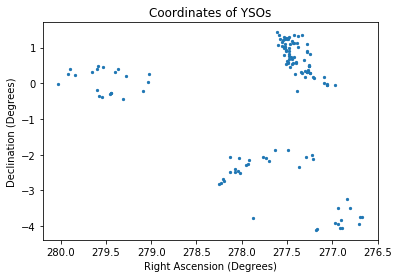

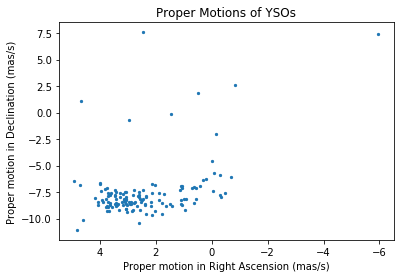

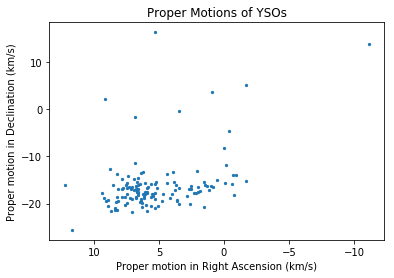

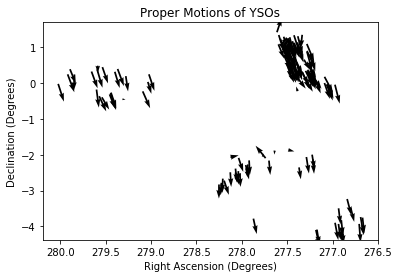

The mean proper motion in ra is  5.3667474149 +/- 0.341356093059
The mean proper motion in dec is  -15.4543655217 +/- 0.753882633222
The mean magnitude of proper motion is 17.5338908149 +/- 0.306020197165
The median proper motion in ra is  6.15832757507 +/- 0.42782641729
The median proper motion in dec is  -17.0584680766 +/- 0.944851762094
The median magnitude of proper motion is 18.1472281899 +/- 0.38353943941
The standard deviation of proper motion is 3.71029770742
The median parallax is 2.23829890655 with a standard deviation of  0.231664642753


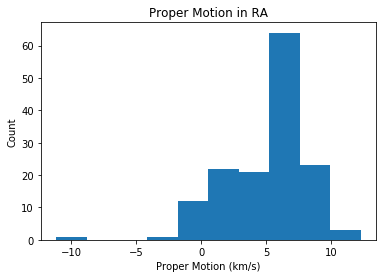

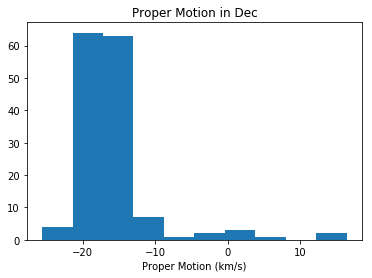

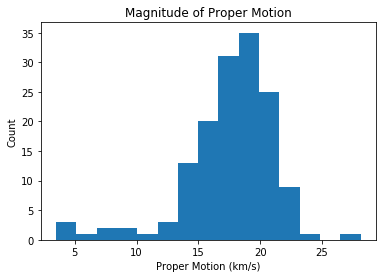

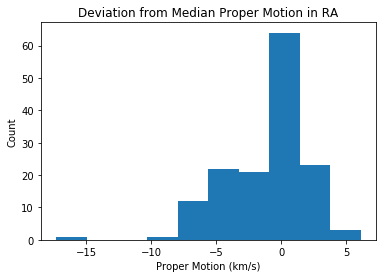

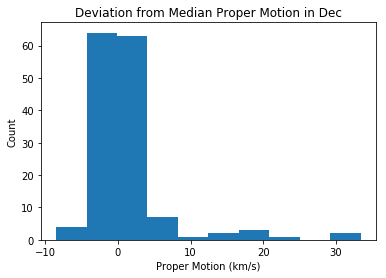

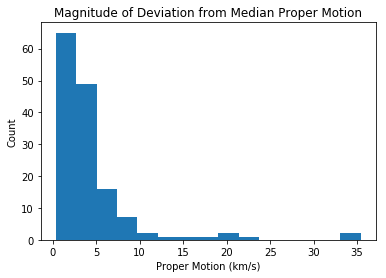

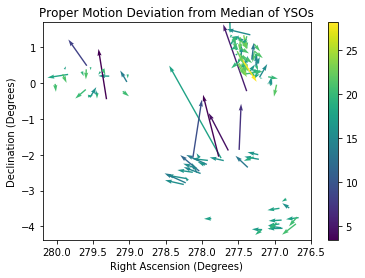

In [112]:
YSO_all = CalculateProperties('YSOs',YSO_match,Gvalues,distance_range=[350.,550.])

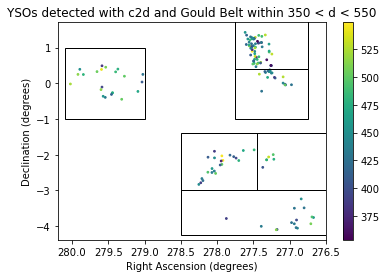

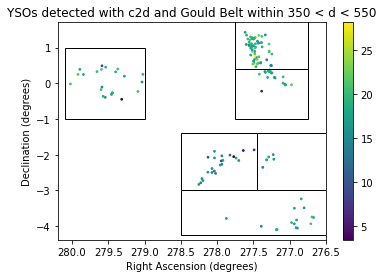

In [113]:
#Plot of selected YSOs
figure = plt.figure()
plt.scatter(YSO_all['ra'],YSO_all['dec'],c=YSO_all['dist'],s=3)
plt.colorbar()
plt.xlabel('Right Ascension (degrees)')
plt.ylabel('Declination (degrees)')
plt.title('YSOs detected with c2d and Gould Belt within 350 < d < 550')
plt.gca().add_patch(Rectangle((ra_min1,dec_min1),width1,height1,fill=False))
plt.gca().add_patch(Rectangle((ra_minW40,dec_minW40),widthW40,heightW40,fill=False))
plt.gca().add_patch(Rectangle((ra_minS,dec_minS),widthS,heightS,fill=False))
plt.gca().add_patch(Rectangle((ra_min2d,dec_min2d),width2d,height2d,fill=False))
plt.gca().add_patch(Rectangle((ra_min3u,dec_min3u),width3u,height3u,fill=False))
plt.gca().add_patch(Rectangle((ra_min3d,dec_min3d),width3d,height3d,fill=False))
plt.gca().invert_xaxis()
plt.savefig('Figures/SelectedYSO_plot.png')
plt.show()

#Plot of selected YSOs
figure = plt.figure()
plt.scatter(YSO_all['ra'],YSO_all['dec'],c=YSO_all['pmmag'],s=3)
plt.colorbar()
plt.xlabel('Right Ascension (degrees)')
plt.ylabel('Declination (degrees)')
plt.title('YSOs detected with c2d and Gould Belt within 350 < d < 550')
plt.gca().add_patch(Rectangle((ra_min1,dec_min1),width1,height1,fill=False))
plt.gca().add_patch(Rectangle((ra_minW40,dec_minW40),widthW40,heightW40,fill=False))
plt.gca().add_patch(Rectangle((ra_minS,dec_minS),widthS,heightS,fill=False))
plt.gca().add_patch(Rectangle((ra_min2d,dec_min2d),width2d,height2d,fill=False))
plt.gca().add_patch(Rectangle((ra_min3u,dec_min3u),width3u,height3u,fill=False))
plt.gca().add_patch(Rectangle((ra_min3d,dec_min3d),width3d,height3d,fill=False))
plt.gca().invert_xaxis()
plt.savefig('Figures/SelectedYSO_plot.png')
plt.show()

Number of YSO_Reg1 matches in the correct distance interval: 22
Number of _match with parallax > 5, 10, 20:  21 11 6


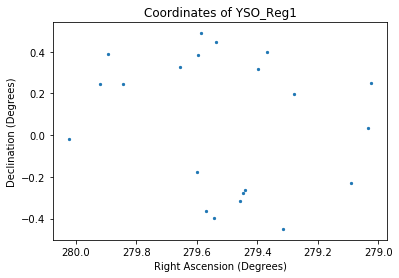

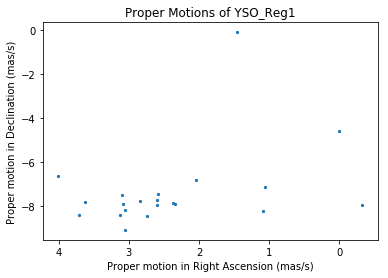

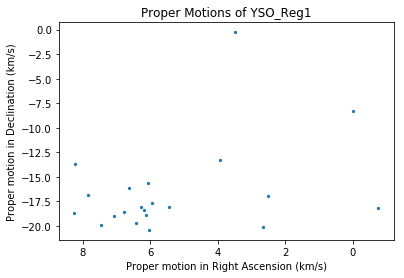

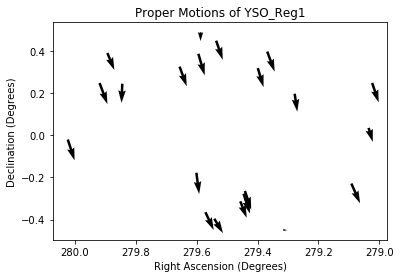

The mean proper motion in ra is  6.00959354926 +/- 0.395434653697
The mean proper motion in dec is  -16.2794521532 +/- 1.6225062211
The mean magnitude of proper motion is 17.4558425347 +/- 0.898842176962
The median proper motion in ra is  6.1346574026 +/- 0.495603841864
The median proper motion in dec is  -18.4214384498 +/- 2.03350998479
The median magnitude of proper motion is 18.7508228671 +/- 1.1265316076
The standard deviation of proper motion is 4.21594351242
The median parallax is 2.08802426198 with a standard deviation of  0.209761884555


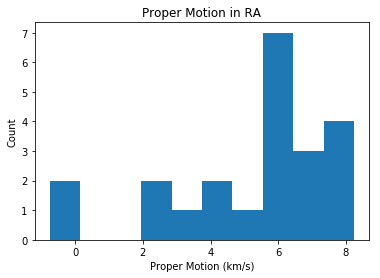

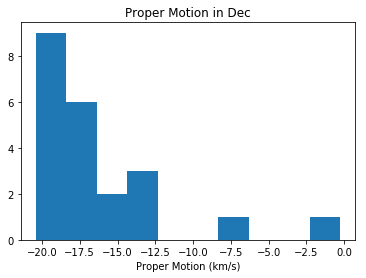

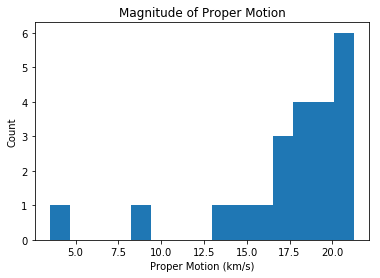

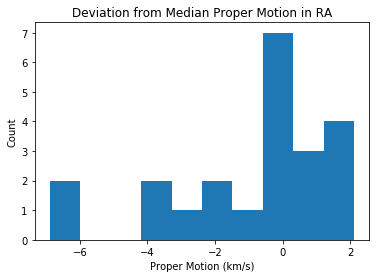

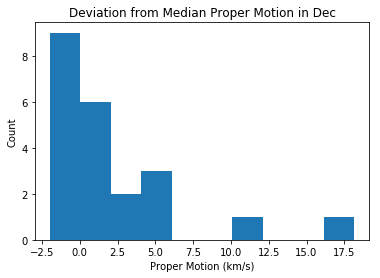

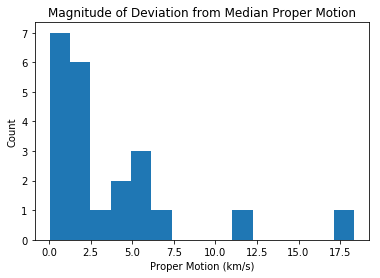

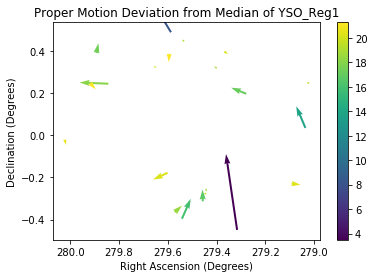

In [114]:
YSO_Reg1 = CalculateProperties('YSO_Reg1',YSO_match,Gvalues, distance_range=[350.,550.], sky_region = sky_region1)

Number of YSO_Reg2 matches in the correct distance interval: 44
Number of _match with parallax > 5, 10, 20:  37 22 14


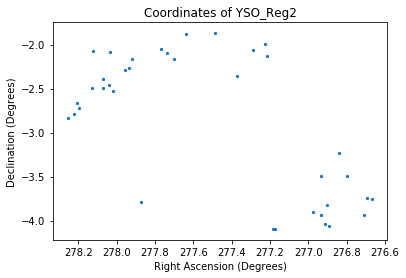

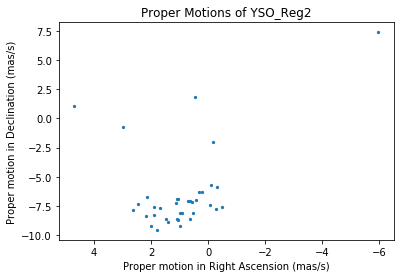

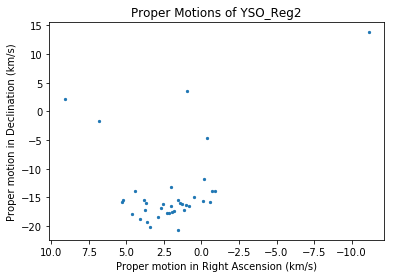

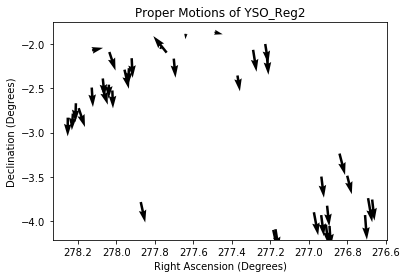

The mean proper motion in ra is  2.23925998653 +/- 0.791311468532
The mean proper motion in dec is  -12.2529753526 +/- 1.84705955206
The mean magnitude of proper motion is 15.3220010729 +/- 0.563645725489
The median proper motion in ra is  2.15385178379 +/- 0.991761850531
The median proper motion in dec is  -16.0919288984 +/- 2.31494584906
The median magnitude of proper motion is 16.3516591183 +/- 0.706425156193
The standard deviation of proper motion is 3.73880277227
The median parallax is 2.27172978858 with a standard deviation of  0.220981264773


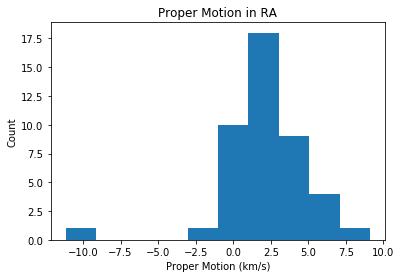

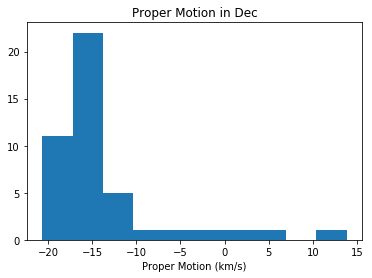

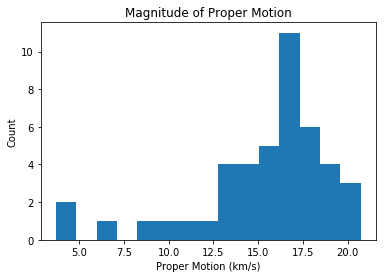

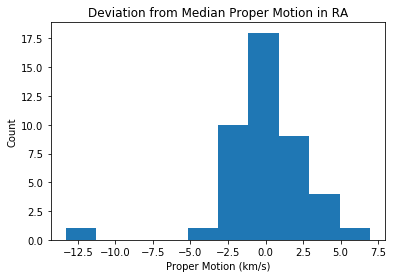

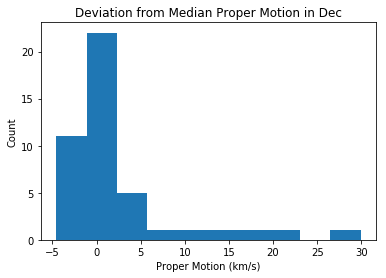

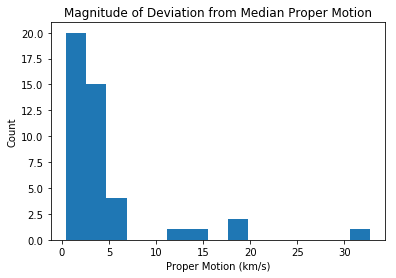

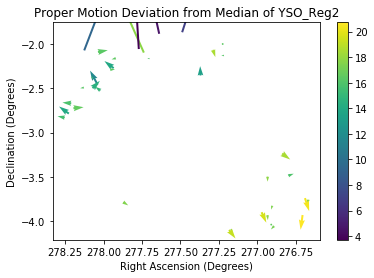

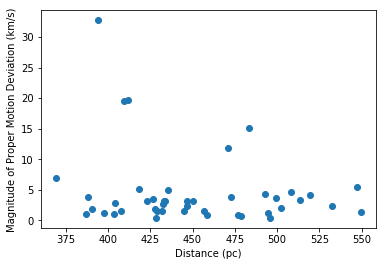

In [115]:
YSO_Reg2 = CalculateProperties('YSO_Reg2',YSO_match,Gvalues, distance_range=[350.,550.], sky_region = sky_region2)

plt.scatter(YSO_Reg2['dist'], YSO_Reg2['rpmmag'])
plt.xlabel('Distance (pc)')
plt.ylabel('Magnitude of Proper Motion Deviation (km/s)')
plt.show()

There are 5 outliers


The GAIA id is 6782
The outlier is at a distance of 483.4 pc
The proper motion magnitude is 15.15 km/s
The GB id is 520
The difference in RA is  0.085 arcseconds
The difference in Dec is  0.1 arcseconds
The Gould_Belt_ID is  SSTGBS J182957.4-015154


/astromake/opt/python/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in log10
/astromake/opt/python/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in log10


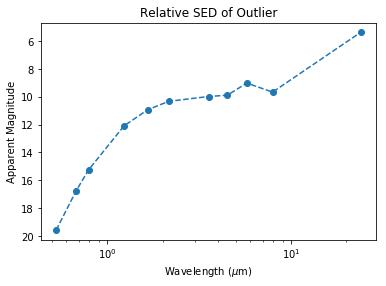

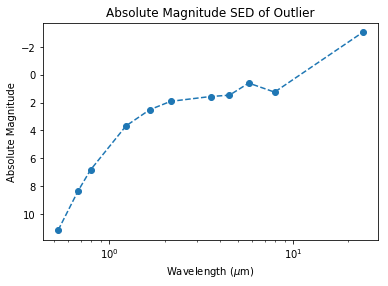

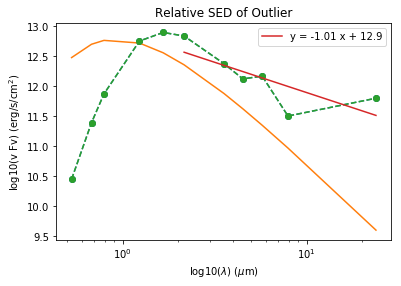

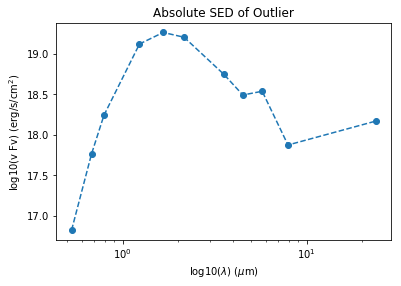

[  0.52786   0.67737   0.79191   1.235     1.662     2.159     3.55726
   4.50493   5.73857   7.92737  23.84331]
[  4.98484448e-05   5.57946265e-04   1.97064412e-03   2.32963581e-02
   4.35612068e-02   4.93396225e-02   2.82000000e-02   1.99000000e-02
   2.82000000e-02   8.44000000e-03   5.02000000e-02]
[  5.67939336e+14   4.42583017e+14   3.78568850e+14   2.42746930e+14
   1.80380540e+14   1.38857090e+14   8.42762289e+13   6.65476396e+13
   5.22416661e+13   3.78173919e+13   1.25734413e+13]
[  2.83108926e+10   2.46937541e+11   7.46024477e+11   5.65511940e+12
   7.85759402e+12   6.85115642e+12   2.37658965e+12   1.32429803e+12
   1.47321498e+12   3.19178788e+11   6.31186752e+11]
The GAIA id is 3762
The outlier is at a distance of 470.68 pc
The proper motion magnitude is 11.79 km/s
The GB id is 690
The difference in RA is  0.094 arcseconds
The difference in Dec is  0.054 arcseconds
The Gould_Belt_ID is  SSTGBS J183033.2-015256


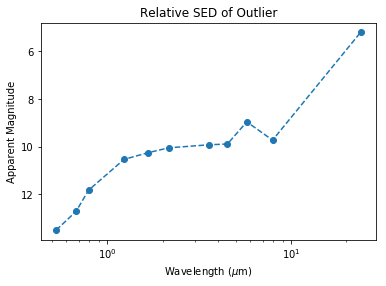

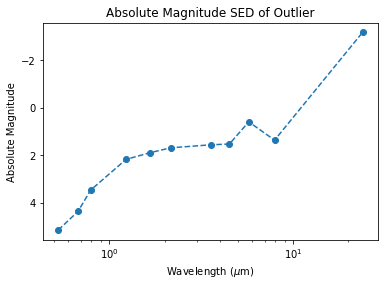

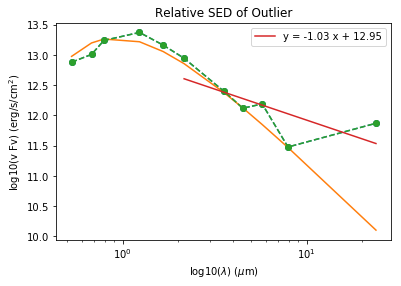

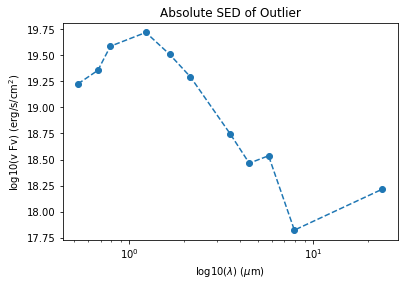

[  0.52786   0.67737   0.79191   1.235     1.662     2.159     3.55726
   4.50493   5.73857   7.92737  23.84331]
[ 0.0133583   0.0230853   0.04593415  0.09711546  0.08066775  0.0635617
  0.0297      0.0198      0.0297      0.00796     0.0591    ]
[  5.67939336e+14   4.42583017e+14   3.78568850e+14   2.42746930e+14
   1.80380540e+14   1.38857090e+14   8.42762289e+13   6.65476396e+13
   5.22416661e+13   3.78173919e+13   1.25734413e+13]
[  7.58670524e+12   1.02171602e+13   1.73892386e+13   2.35744805e+13
   1.45508919e+13   8.82599204e+12   2.50300400e+12   1.31764326e+12
   1.55157748e+12   3.01026439e+11   7.43090379e+11]
The GAIA id is 3527
The outlier is at a distance of 394.29 pc
The proper motion magnitude is 32.73 km/s
The GB id is 762
The difference in RA is  0.025 arcseconds
The difference in Dec is  0.029 arcseconds
The Gould_Belt_ID is  SSTGBS J183057.1-020543


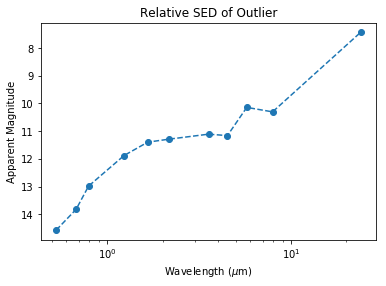

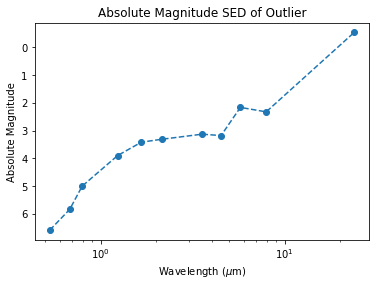

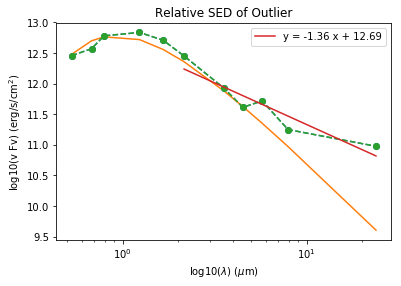

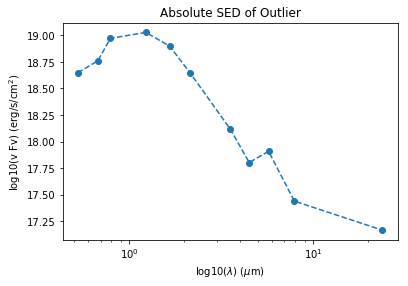

[  0.52786   0.67737   0.79191   1.235     1.662     2.159     3.55726
   4.50493   5.73857   7.92737  23.84331]
[ 0.00502918  0.00837314  0.01590541  0.02818957  0.02825531  0.02028596
  0.00997     0.00614     0.00997     0.00468     0.00751   ]
[  5.67939336e+14   4.42583017e+14   3.78568850e+14   2.42746930e+14
   1.80380540e+14   1.38857090e+14   8.42762289e+13   6.65476396e+13
   5.22416661e+13   3.78173919e+13   1.25734413e+13]
[  2.85626999e+12   3.70580760e+12   6.02129270e+12   6.84293051e+12
   5.09670878e+12   2.81685007e+12   8.40234002e+11   4.08602507e+11
   5.20849411e+11   1.76985394e+11   9.44265439e+10]
The GAIA id is 3813
The outlier is at a distance of 412.08 pc
The proper motion magnitude is 19.73 km/s
The GB id is 793
The difference in RA is  0.065 arcseconds
The difference in Dec is  0.064 arcseconds
The Gould_Belt_ID is  SSTGBS J183105.0-020318


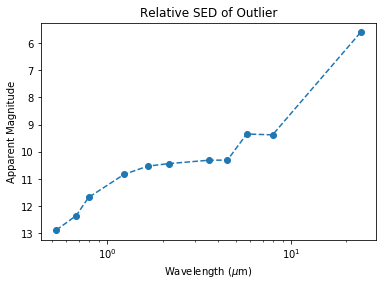

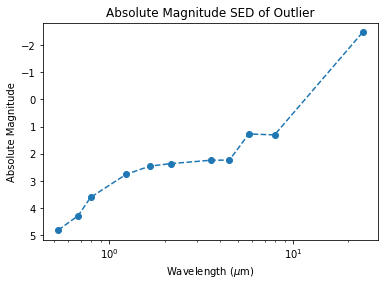

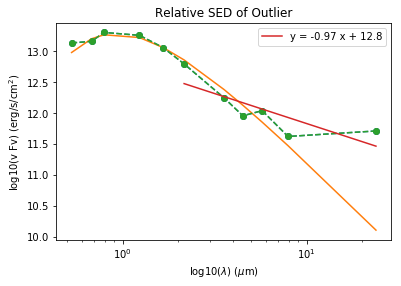

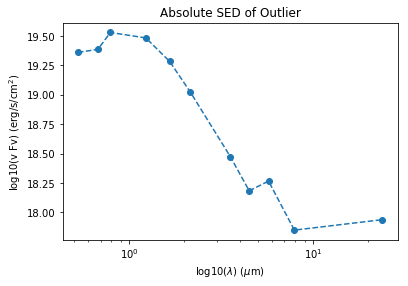

[  0.52786   0.67737   0.79191   1.235     1.662     2.159     3.55726
   4.50493   5.73857   7.92737  23.84331]
[ 0.02381854  0.03243254  0.05284327  0.07400964  0.06296514  0.04458571
  0.0208      0.0135      0.0208      0.011       0.0406    ]
[  5.67939336e+14   4.42583017e+14   3.78568850e+14   2.42746930e+14
   1.80380540e+14   1.38857090e+14   8.42762289e+13   6.65476396e+13
   5.22416661e+13   3.78173919e+13   1.25734413e+13]
[  1.35274883e+13   1.43540901e+13   2.00048157e+13   1.79656137e+13
   1.13576862e+13   6.19104177e+12   1.75294556e+12   8.98393134e+11
   1.08662666e+12   4.15991311e+11   5.10481716e+11]
The GAIA id is 44626
The outlier is at a distance of 409.52 pc
The proper motion magnitude is 19.5 km/s
The GB id is 1093
The difference in RA is  0.037 arcseconds
The difference in Dec is  0.008 arcseconds
The Gould_Belt_ID is  SSTGBS J183230.1-020413


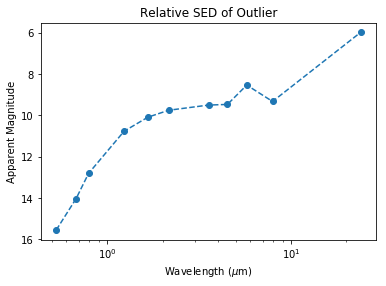

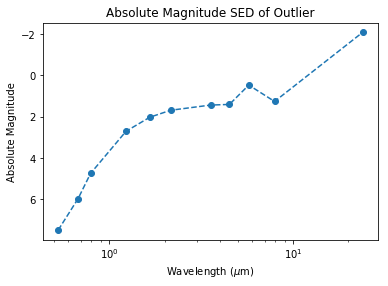

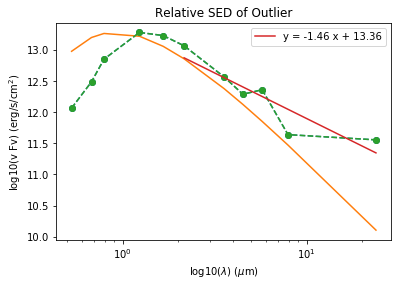

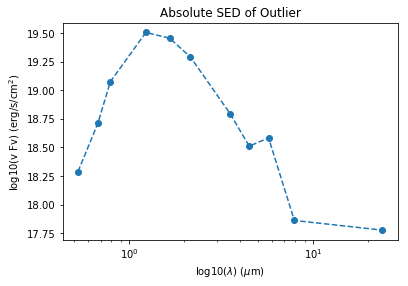

[  0.52786   0.67737   0.79191   1.235     1.662     2.159     3.55726
   4.50493   5.73857   7.92737  23.84331]
[ 0.00204281  0.00693389  0.01870043  0.07843108  0.0940806   0.08363647
  0.0438      0.0291      0.0438      0.0115      0.0285    ]
[  5.67939336e+14   4.42583017e+14   3.78568850e+14   2.42746930e+14
   1.80380540e+14   1.38857090e+14   8.42762289e+13   6.65476396e+13
   5.22416661e+13   3.78173919e+13   1.25734413e+13]
[  1.16018997e+12   3.06882253e+12   7.07940097e+12   1.90389047e+13
   1.69703089e+13   1.16135175e+13   3.69129883e+12   1.93653631e+12
   2.28818498e+12   4.34900007e+11   3.58343076e+11]


In [116]:
condition = YSO_Reg2['rpmmag']>10
rpmmag = YSO_Reg2['rpmmag'][np.where(condition)]
shift = [3.25,3.75,3.25,3.75,3.75]
CheckOutlier(condition, YSO_Reg2['id'],YSO_match,c2dYSO_match,GTab,Gdist,GBYSO,rpmmag,shift)

Number of YSO_RegS matches in the correct distance interval: 6
Number of _match with parallax > 5, 10, 20:  4 2 1


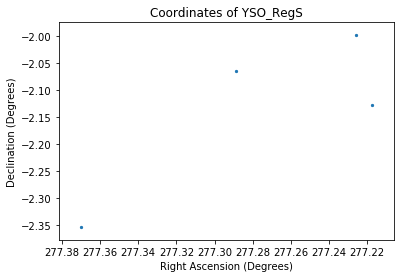

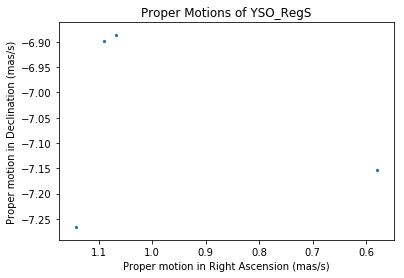

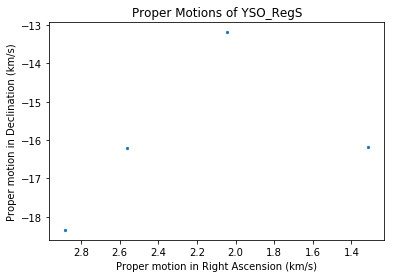

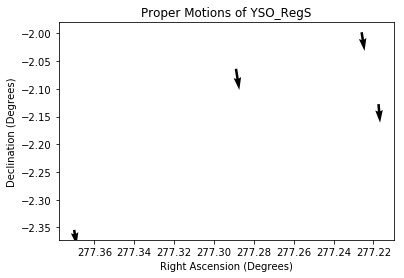

The mean proper motion in ra is  1.93710988336 +/- 0.441456612166
The mean proper motion in dec is  -16.1957402729 +/- 0.0156135189265
The mean magnitude of proper motion is 16.3598358614 +/- 0.890218812943
The median proper motion in ra is  1.93710988336 +/- 0.553283813039
The median proper motion in dec is  -16.1957402729 +/- 0.0195686440038
The median magnitude of proper motion is 16.3228501582 +/- 1.11572382357
The standard deviation of proper motion is 2.18058185114
The median parallax is 2.0564806995 with a standard deviation of  0.193931892008


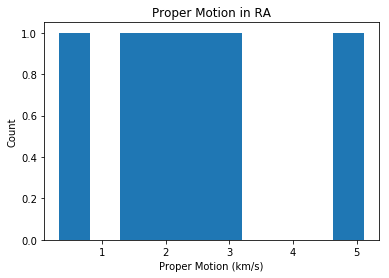

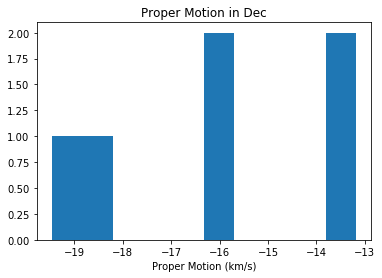

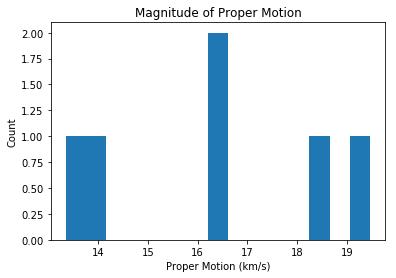

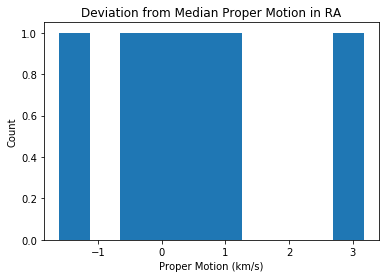

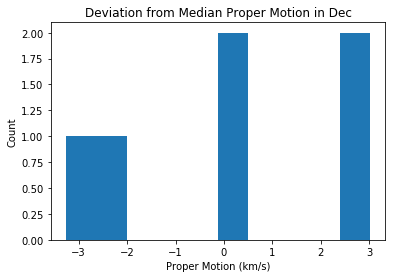

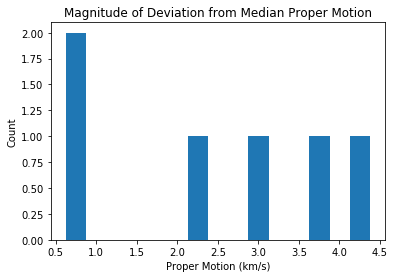

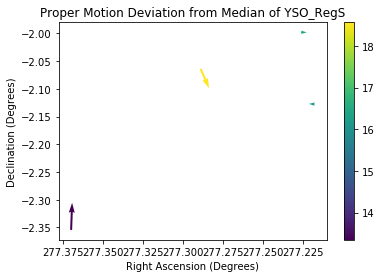

[276.5, 277.45, -3.0, -1.4]


In [86]:
YSO_S = CalculateProperties('YSO_RegS',YSO_match,Gvalues,distance_range=[350.,550.],sky_region = sky_regionS)
print(sky_regionS)

Number of YSO_RegW40 matches in the correct distance interval: 23
Number of _match with parallax > 5, 10, 20:  19 12 8


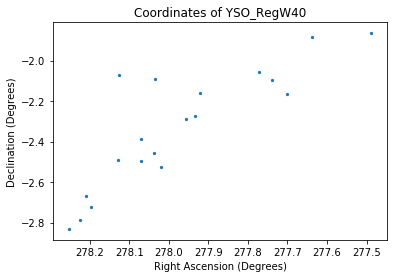

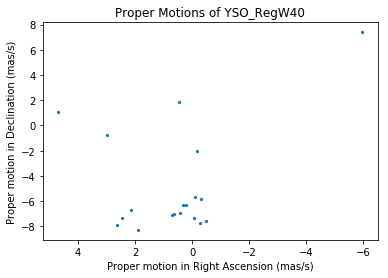

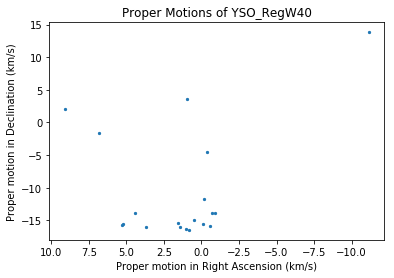

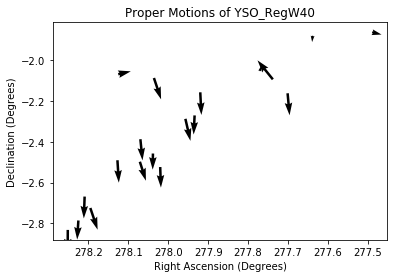

The mean proper motion in ra is  1.85418512163 +/- 1.41033678233
The mean proper motion in dec is  -8.22310489672 +/- 2.90097593222
The mean magnitude of proper motion is 13.3643266914 +/- 0.820576625045
The median proper motion in ra is  1.23783109963 +/- 1.76759502767
The median proper motion in dec is  -15.6529414779 +/- 3.63583414787
The median magnitude of proper motion is 14.9522279496 +/- 1.02844028492
The standard deviation of proper motion is 3.93534724569
The median parallax is 2.2953684808 with a standard deviation of  0.235813313045


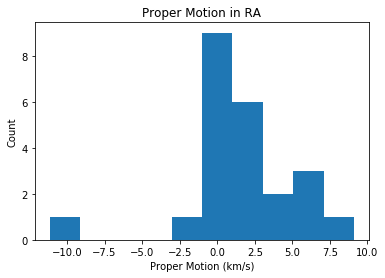

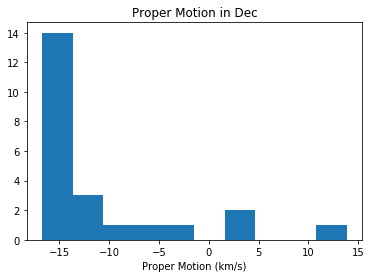

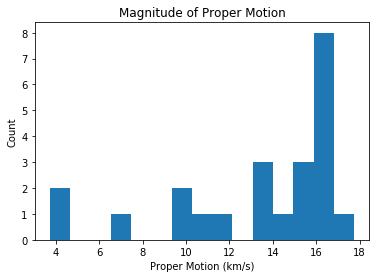

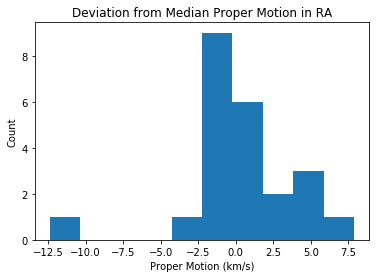

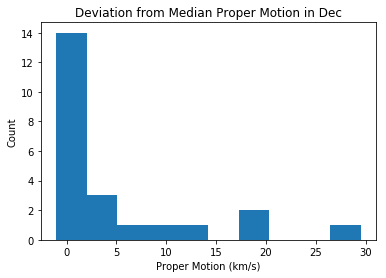

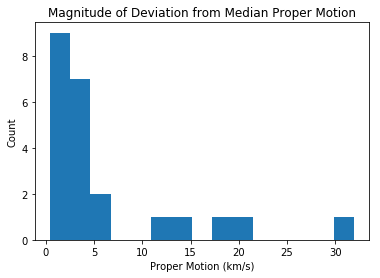

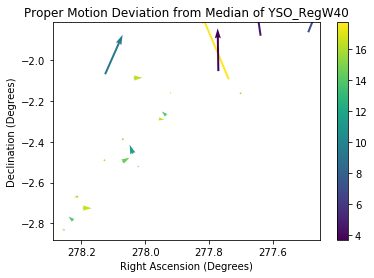

[277.45, 278.5, -3.0, -1.4]


In [87]:
YSO_W40 = CalculateProperties('YSO_RegW40',YSO_match,Gvalues,distance_range=[350.,550.],sky_region = sky_regionW40)
print(sky_regionW40)

Number of YSO_WestArm matches in the correct distance interval: 15
Number of _match with parallax > 5, 10, 20:  14 8 5


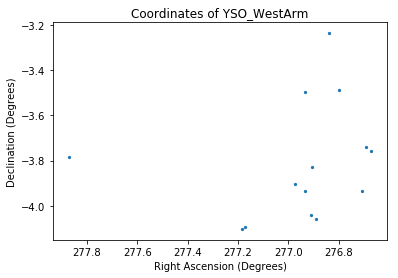

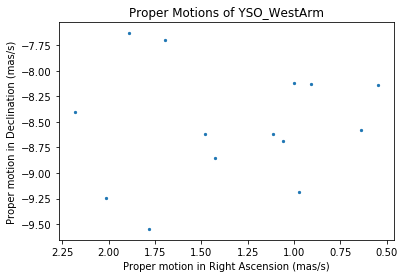

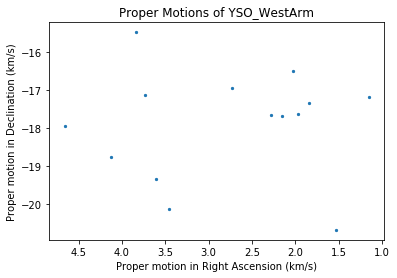

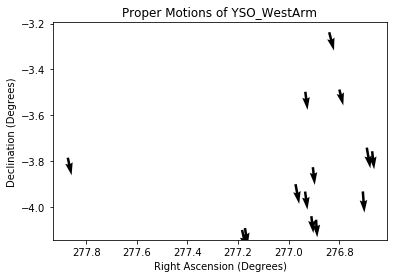

The mean proper motion in ra is  2.89240980968 +/- 0.404865087238
The mean proper motion in dec is  -17.3120898063 +/- 0.367551998236
The mean magnitude of proper motion is 17.9086345424 +/- 0.396433163749
The median proper motion in ra is  2.94578237037 +/- 0.507423137541
The median proper motion in dec is  -17.2460160079 +/- 0.460658115588
The median magnitude of proper motion is 17.71782022 +/- 0.496855288627
The standard deviation of proper motion is 1.53537904108
The median parallax is 2.31367860064 with a standard deviation of  0.177174853793


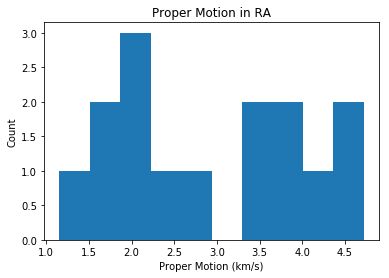

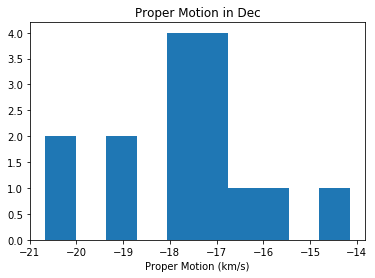

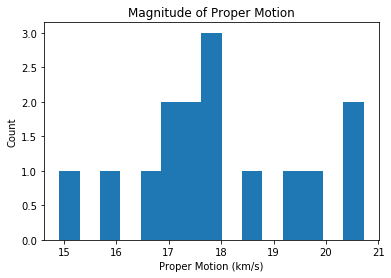

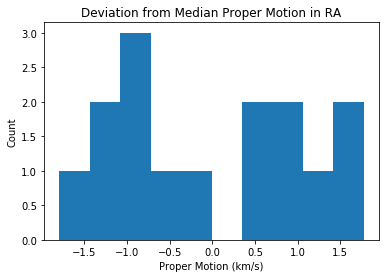

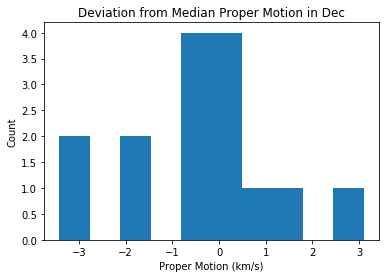

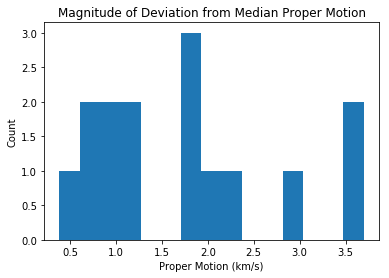

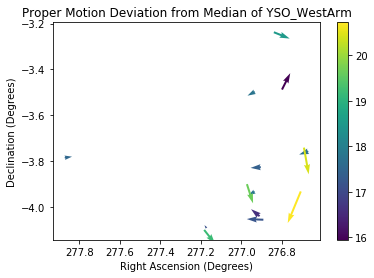

In [89]:
YSO_WestArm = CalculateProperties('YSO_WestArm',YSO_match,Gvalues,distance_range=[350.,550.],\
                                  sky_region = sky_region2d)

Number of YSO_Reg3 matches in the correct distance interval: 81
Number of _match with parallax > 5, 10, 20:  77 53 23


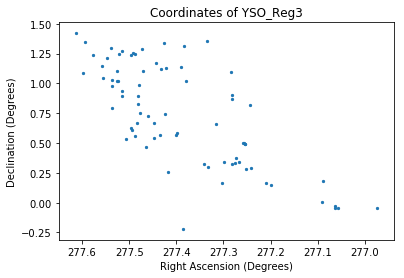

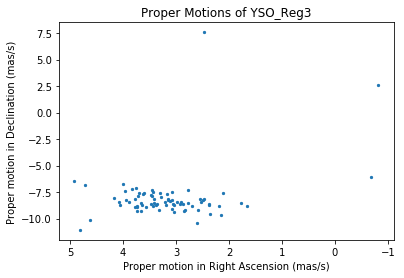

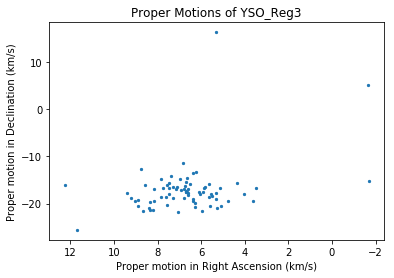

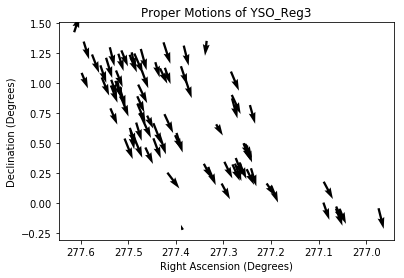

The mean proper motion in ra is  6.53152884784 +/- 0.297243196028
The mean proper motion in dec is  -16.6120000646 +/- 0.828832690027
The mean magnitude of proper motion is 18.7566094669 +/- 0.322185478387
The median proper motion in ra is  6.68167170195 +/- 0.372539099803
The median proper motion in dec is  -17.5174704124 +/- 1.03878772788
The median magnitude of proper motion is 18.7401217818 +/- 0.4037996149
The standard deviation of proper motion is 2.89966930548
The median parallax is 2.27254500916 with a standard deviation of  0.236982700631


/astromake/opt/python/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in true_divide


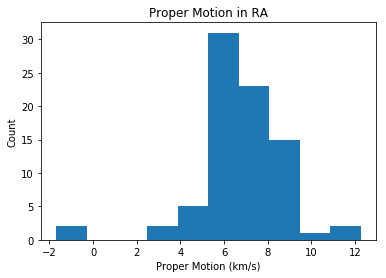

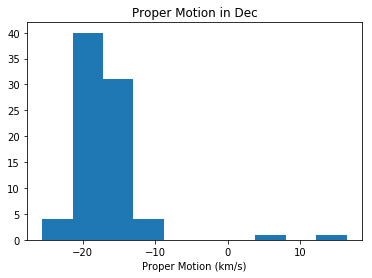

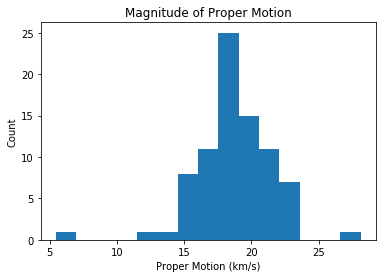

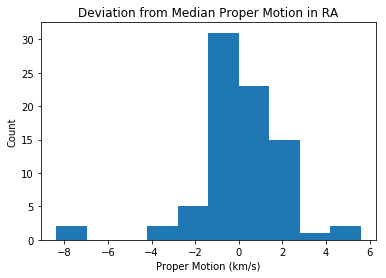

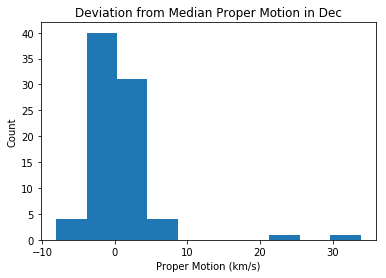

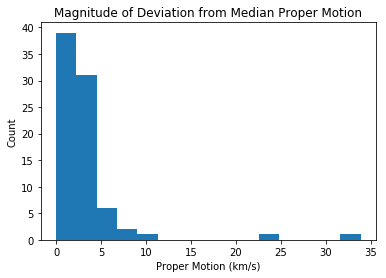

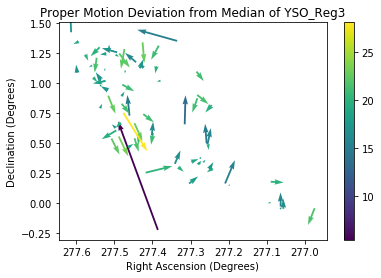

ValueError: too many values to unpack (expected 3)

In [90]:
YSO_Reg3_properties, YSO_Reg3_values,YSOabs_pmmag3 = CalculateProperties('YSO_Reg3',YSO_match,Gvalues,\
                                                           distance_range=[350.,550.],\
                                                           sky_region = sky_region3)

raYSO_Reg3 = YSO_Reg3_properties[0][:]
decYSO_Reg3 = YSO_Reg3_properties[1][:]
pmraYSO_Reg3 = YSO_Reg3_properties[2][:]
pmdecYSO_Reg3 = YSO_Reg3_properties[3][:]
pmra_eYSO_Reg3 = YSO_Reg3_properties[4][:]
pmdec_eYSO_Reg3 = YSO_Reg3_properties[5][:]
parYSO_Reg3 = YSO_Reg3_properties[6][:]
par_snYSO_Reg3 = YSO_Reg3_properties[7][:]
distYSO_Reg3 = YSO_Reg3_properties[8][:]
pmra_kmYSO_Reg3 = YSO_Reg3_properties[9][:]
pmdec_kmYSO_Reg3 = YSO_Reg3_properties[10][:]
rpmraYSO_Reg3 = YSO_Reg3_properties[11][:]
rpmdecYSO_Reg3 = YSO_Reg3_properties[12][:]
pmmagYSO_Reg3 = YSO_Reg3_properties[13][:]
parsn10YSO_Reg3 = YSO_Reg3_properties[14][:]
parsn5YSO_Reg3 = YSO_Reg3_properties[15][:]
parsn10YSO_Reg3 = YSO_Reg3_properties[16][:]
mean_pmraYSO_Reg3 = YSO_Reg3_values[0]
mean_pmdecYSO_Reg3 = YSO_Reg3_values[1]
median_pmraYSO_Reg3 = YSO_Reg3_values[2]
median_pmdecYSO_Reg3 = YSO_Reg3_values[3]

print(sky_region3)

Number of YSO_Main matches in the correct distance interval: 61
Number of _match with parallax > 5, 10, 20:  57 39 15


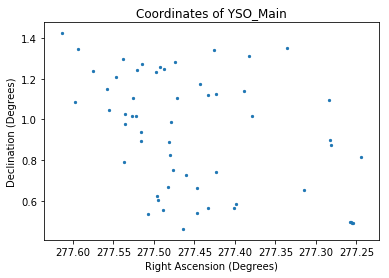

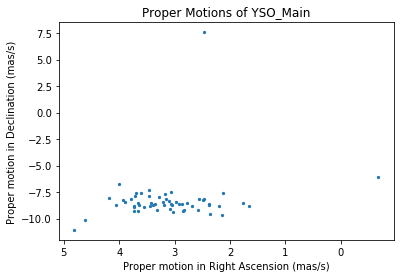

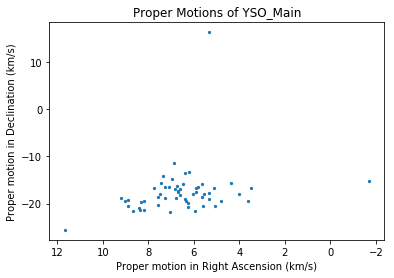

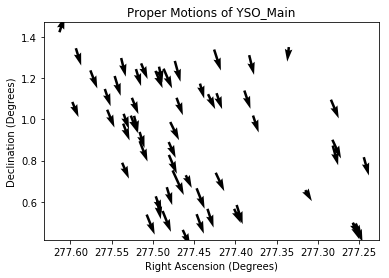

The mean proper motion in ra is  6.54481651027 +/- 0.323421769538
The mean proper motion in dec is  -17.0748823919 +/- 0.958096719415
The mean magnitude of proper motion is 19.061477652 +/- 0.349897325761
The median proper motion in ra is  6.67833460211 +/- 0.405349076078
The median proper motion in dec is  -17.6471556206 +/- 1.20079616336
The median magnitude of proper motion is 18.8927055846 +/- 0.438531264985
The standard deviation of proper motion is 2.73278547513
The median parallax is 2.27869366981 with a standard deviation of  0.255909838478


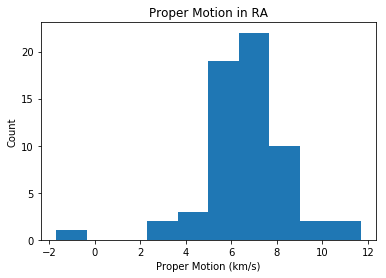

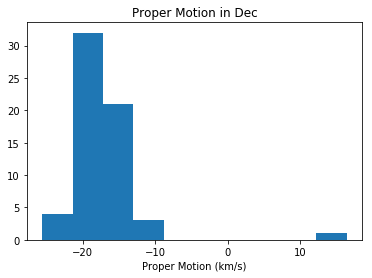

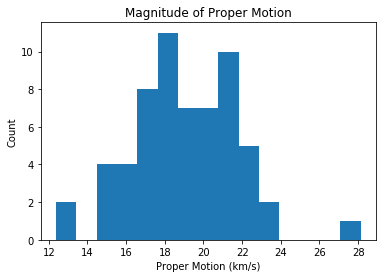

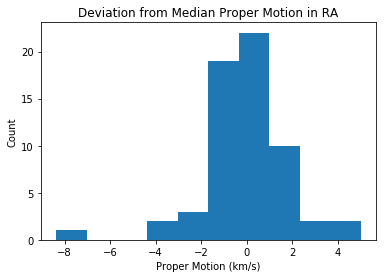

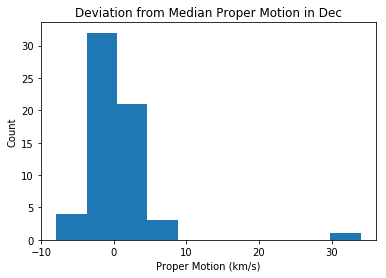

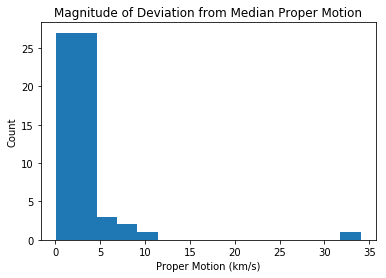

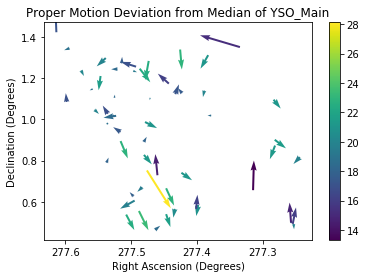

In [91]:
YSO_Main = CalculateProperties('YSO_Main',YSO_match,Gvalues, distance_range=[350.,550.],sky_region = sky_region3u)

Number of YSO_B matches in the correct distance interval: 20
Number of _match with parallax > 5, 10, 20:  20 14 8


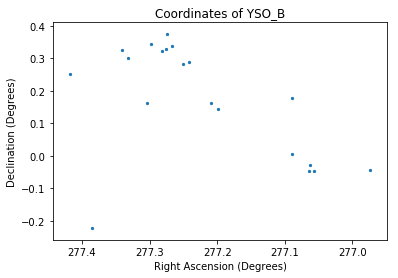

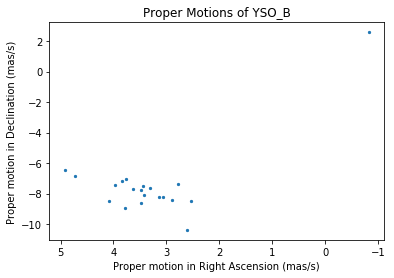

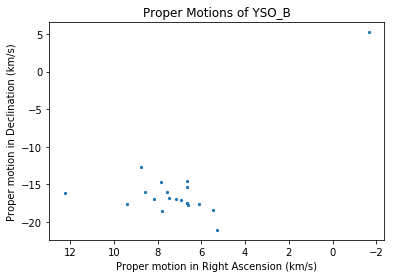

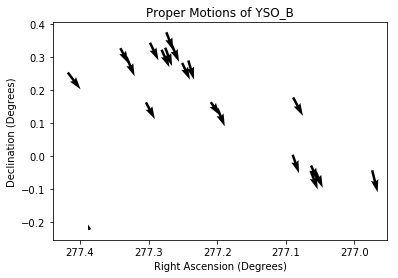

The mean proper motion in ra is  6.49451321677 +/- 0.674082395209
The mean proper motion in dec is  -15.322542153 +/- 1.60013702219
The mean magnitude of proper motion is 17.8267615025 +/- 0.711578489995
The median proper motion in ra is  6.79959562524 +/- 0.844836995631
The median proper motion in dec is  -17.0436590773 +/- 2.00547435155
The median magnitude of proper motion is 18.5695401716 +/- 0.891831381321
The standard deviation of proper motion is 3.18227574991
The median parallax is 2.27252981446 with a standard deviation of  0.166129824217


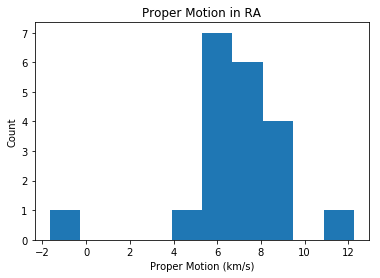

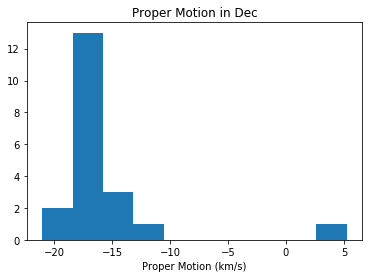

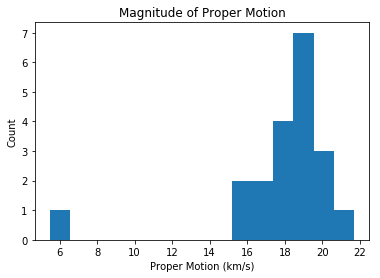

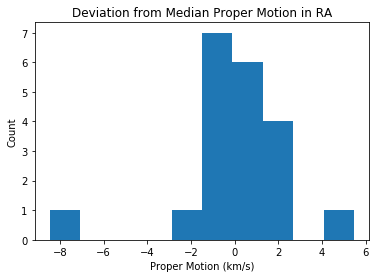

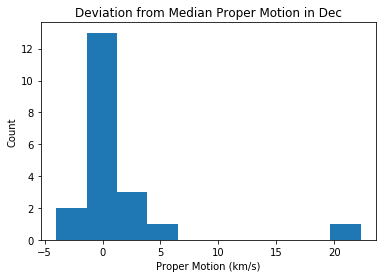

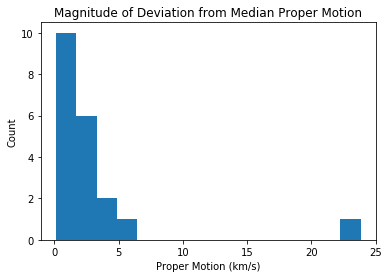

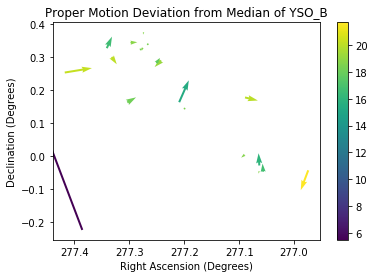

In [92]:
YSO_B = CalculateProperties('YSO_B',YSO_match,Gvalues,distance_range=[350.,550.],sky_region = sky_region3d)

In [95]:
#compare W40 and Serpens South

s,p = scipy.stats.ks_2samp(YSO_W40['pmmag'],YSO_S['pmmag'])
print(p)
s2,p2 = scipy.stats.ks_2samp(YSO_S['pmmag'],YSO_W40['pmmag'])
print(p2)

#compare W40 and Serpens South
s3,p3 = scipy.stats.ks_2samp(YSO_Main['pmmag'],YSO_B['pmmag'])
print(p3)
s4,p4 = scipy.stats.ks_2samp(YSO_B['pmmag'],YSO_Main['pmmag'])
print(p4)


0.462103763227
0.462103763227
0.170271018899
0.170271018899


Number of Stars+Dust matches in the correct distance interval: 82
Number of _match with parallax > 5, 10, 20:  65 43 26


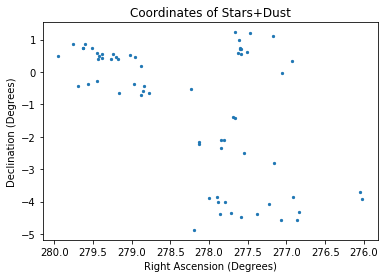

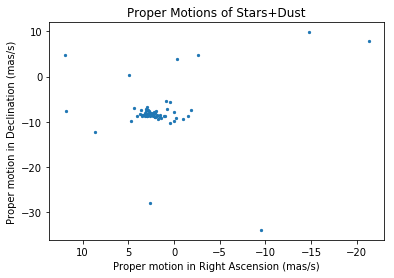

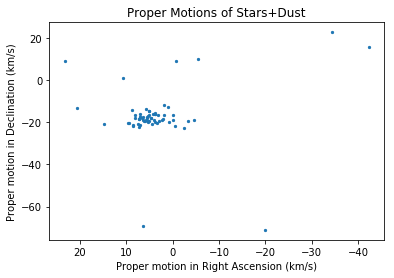

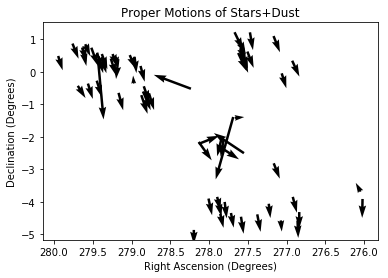

Mean proper motion (Ra,Dec):  3.04455827594 -13.7361372551
Median proper motion (Ra,Dec):  4.7611715435 -17.5411000269
The mean proper motion in ra is  3.04455827594 +/- 1.59175680658
The mean proper motion in dec is  -13.7361372551 +/- 1.61767903098
The mean magnitude of proper motion is 19.5312596488 +/- 0.939512874727
The median proper motion in ra is  4.7611715435 +/- 1.99497130886
The median proper motion in dec is  -17.5411000269 +/- 2.02745999916
The median magnitude of proper motion is 18.8985921106 +/- 1.17750476809


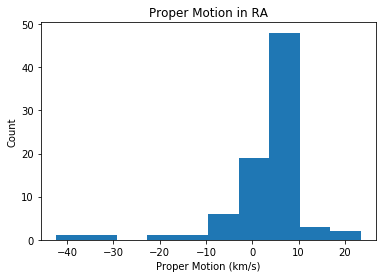

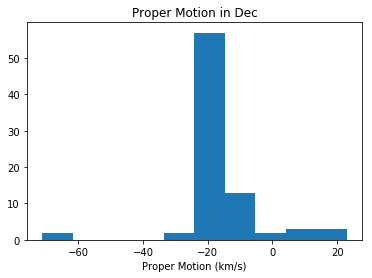

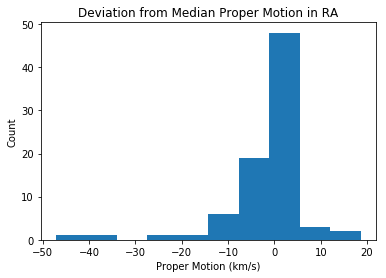

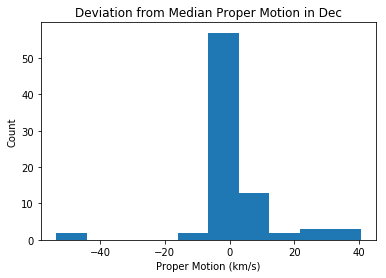

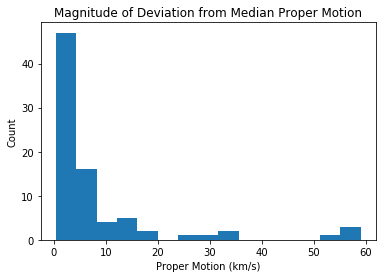

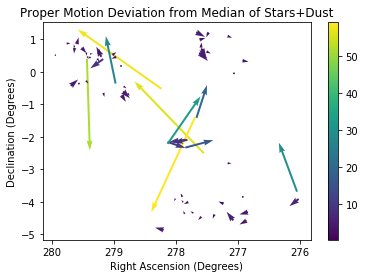

In [33]:
SD_properties, SD_values = CalculateProperties('Stars+Dust',SD_match,Gvalues,distance_range=[350.,550.])

raSD = SD_properties[0][:]
decSD = SD_properties[1][:]
pmraSD = SD_properties[2][:]
pmdecSD = SD_properties[3][:]
pmra_eSD = SD_properties[4][:]
pmdec_eSD = SD_properties[5][:]
parSD = SD_properties[6][:]
par_snSD = SD_properties[7][:]
distSD = SD_properties[8][:]
pmra_kmSD = SD_properties[9][:]
pmdec_kmSD = SD_properties[10][:]
rpmraSD = SD_properties[11][:]
rpmdecSD = SD_properties[12][:]
pmmagSD = SD_properties[13][:]
parsn10SD = SD_properties[14][:]
parsn5SD = SD_properties[15][:]
parsn10SD = SD_properties[16][:]
mean_pmraSD = SD_values[0]
mean_pmdecSD = SD_values[1]
median_pmraSD = SD_values[2]
median_pmdecSD = SD_values[3]

Number of All Sources matches in the correct distance interval: 229
Number of _match with parallax > 5, 10, 20:  200 129 69


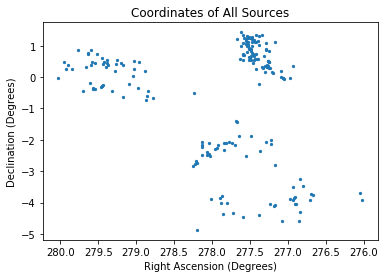

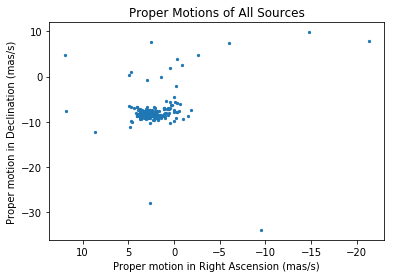

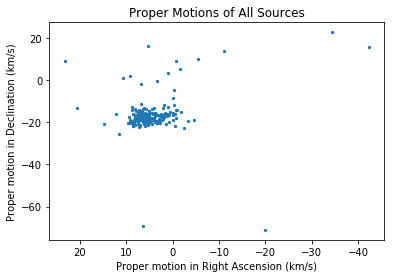

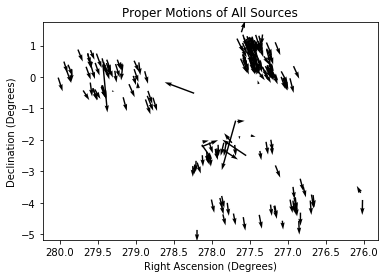

Mean proper motion (Ra,Dec):  4.59268436858 -14.8816227662
Median proper motion (Ra,Dec):  5.90042519817 -17.138520439
The mean proper motion in ra is  4.59268436858 +/- 0.585319597308
The mean proper motion in dec is  -14.8816227662 +/- 0.740571383673
The mean magnitude of proper motion is 18.2546118021 +/- 0.433745178503
The median proper motion in ra is  5.90042519817 +/- 0.733589326154
The median proper motion in dec is  -17.138520439 +/- 0.928168584849
The median magnitude of proper motion is 18.4819089799 +/- 0.543618964211


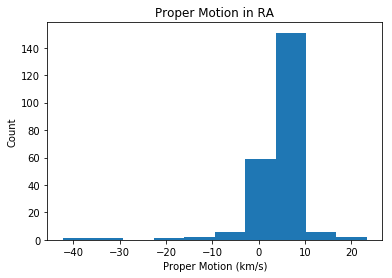

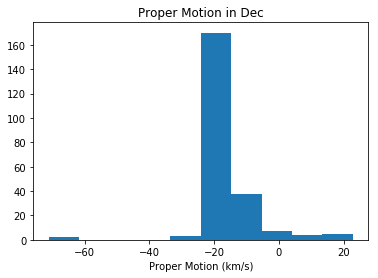

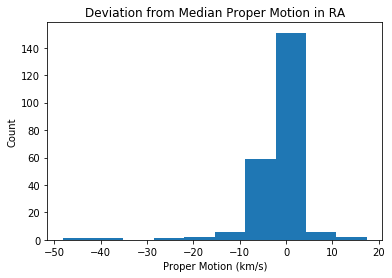

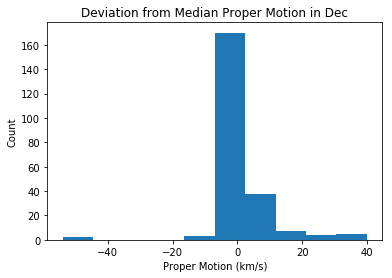

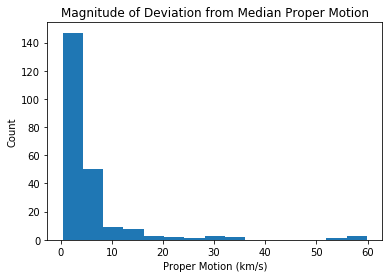

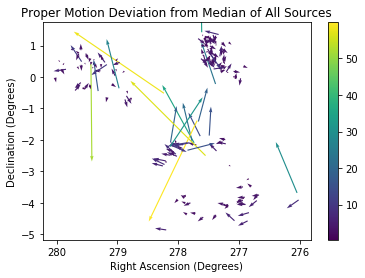

In [34]:
ALL_properties, ALL_values = CalculateProperties('All Sources',ALL_match,Gvalues,distance_range=[350.,550.])

raALL = ALL_properties[0][:]
decALL = ALL_properties[1][:]
pmraALL = ALL_properties[2][:]
pmdecALL = ALL_properties[3][:]
pmra_eALL = ALL_properties[4][:]
pmdec_eALL = ALL_properties[5][:]
parALL = ALL_properties[6][:]
par_snALL = ALL_properties[7][:]
distALL = ALL_properties[8][:]
pmra_kmALL = ALL_properties[9][:]
pmdec_kmALL = ALL_properties[10][:]
rpmraALL = ALL_properties[11][:]
rpmdecALL = ALL_properties[12][:]
pmmagALL = ALL_properties[13][:]
parsn10ALL = ALL_properties[14][:]
parsn5ALL = ALL_properties[15][:]
parsn10ALL = ALL_properties[16][:]
mean_pmraALL = ALL_values[0]
mean_pmdecALL = ALL_values[1]
median_pmraALL = ALL_values[2]
median_pmdecALL = ALL_values[3]

In [33]:
#determine high proper motion YSOs 
high_pmYSO = pmmagYSO[parsn5YSO] > 8.
for i in range(0,len(high_pmYSO)):
    if(high_pmYSO[i]):
        j = YSO_match[i] #identifier of YSO match
        print(Gra[j],Gdec[j],c2dYSOobj[i],rpmraYSO[i],rpmdecYSO[i],pmmagYSO[i])

279.453790029 -4.79575643825 YSOc_red -7.85250703892 1.88416356125 8.07539095783
279.453790029 -4.79575643825 YSOc_star+dust(IR2) -7.8211772115 22.2770480116 23.610118193
279.453790029 -4.79575643825 YSOc_red 0.457416293269 -1.09453800606 1.18627278147
279.453790029 -4.79575643825 YSOc_star+dust(IR2) 2.04151661098 4.69523540054 5.11986577357
279.453790029 -4.79575643825 YSOc_star+dust(IR2) -4.84553161983 0.884808653933 4.92565356403
277.315204689 0.656302217746 YSOc_star+dust(IR2) -3.59690376358 0.840646953489 3.69383323728
279.453790029 -4.79575643825 YSOc -1.04606828964 3.87910712064 4.01767730411
277.332099703 0.300794132453 YSOc_star+dust(IR2) -5.83162694626 -2.40373599115 6.30760014233
279.453790029 -4.79575643825 YSOc_star+dust(MP1) -5.22555284416 20.6584810706 21.309135193
279.453790029 -4.79575643825 YSOc_star+dust(IR2) -5.33387606577 0.590542229074 5.36646755411
279.453790029 -4.79575643825 YSOc_star+dust(IR4) -1.74810241396 3.24958063163 3.6899371717
277.403036109 0.799375442

In [ ]:
#FIXED determine high proper motion YSOs
for i in range(0,len(pmmagYSO)):
    if(pmmagYSO[i] > 8): 
        j = YSO_match[i] #identifier of YSO match
        print(Gra[j],Gdec[j],c2dYSOobj[i],rpmraYSO[i],rpmdecYSO[i],pmmagYSO[i],par_snYSO[i])
        #figure out difference between i and j

In [ ]:
print(len(YSO_match))
print(len(high_pmYSO))

In [ ]:
#define variables
ra_big = GTab["ra"]
dec_big = GTab["dec"]
par_big = GTab["parallax"]
pare_big = GTab["parallax_error"]
parsn_big = GTab["parallax_over_error"]
pmra_big = GTab["pmra"]
pmdec_big = GTab["pmdec"]
print(len(ra_big))

#count number of sources in distance range
nn = 0
for i in range(0,len(ra_big)):
     dist = 1000/par_big[i]
     if(dist > 350. and dist <550. and parsn_big[i]>10.):
         nn = nn + 1
print("Number of sources in distance range:", nn)


secperyr = 60*60*24*365.25
to_kms = 443./1000. * 1.496e8/secperyr

#find magnitude of proper motion for sources with S/N greater than 10 in parallax
pm_mag = np.zeros(0)
for i in range(0,len(ra_big)):
     dist = 1000/par_big[i]
     if (dist > 350. and dist <550. and parsn_big[i]>10.):
        
        pmra_km = (pmra_big[i]*dist*const.au.value)/(secperyr*1000.0)
        pmdec_km = (pmdec_big[i]*dist*const.au.value)/(secperyr*1000.0)
        #pm2 = pmra_big[i]*pmra_big[i] + pmdec_big[i]*pmdec_big[i]
        pm2 = pmra_km*pmra_km+pmdec_km*pmdec_km
        pm = np.power(pm2,0.5)
        pm_mag = np.append(pm_mag,pm)
        
print(len(pm_mag))

#create histogram of number of sources for each proper motion magnitude
plt.hist(pm_mag,bins=100)
plt.xlabel("Magnitude of Proper Motion (km/sec)")
plt.ylabel("Number of sources with S/N>10 in Parallax")
plt.text(100000,300,"Gaia sources in 5 deg radius of (18:30, -1 deg)")
plt.text(100000,250,"With Parallax S/N > 10")
plt.text(100000,200,"With 350 pc < Dist < 550 pc")
plt.savefig("big-Serp-pms.png")
plt.show()

# WISE Data

In [ ]:
WISE_YSO = Table.read('WISE_SVM_YSO_class1+2.vot',format='votable')
print(WISE_YSO.colnames)
Wra = WISE_YSO['RAJ2000']
Wdec = WISE_YSO['DEJ2000']

In [ ]:
#match up GAIA catalog and WISE YSO catalog
WISE_YSO2MASS = WISE_YSO['_2MASSKey']
WISE_YSO_match = np.empty(len(WISE_YSO2MASS),dtype=int)
WISE_YSO_match.fill(-2)
for j in range(0,len(WISE_YSO2MASS)):
    if(WISE_YSO2MASS[j] in gaia_list):
        WISE_YSO_match[j] = gaia_list.index(WISE_YSO2MASS[j])
    else:
        WISE_YSO_match[j] = -2
good_WISE_YSO = WISE_YSO_match > -1
print(len(WISE_YSO_match[good_WISE_YSO]))
print(np.where(WISE_YSO_match > -1))

In [ ]:
#matching the catalogs 

gaia_coord = SkyCoord(ra=Gra,dec=Gdec,unit=(u.deg,u.deg))
WISE_coord = SkyCoord(ra=Wra,dec=Wdec,unit=(u.deg,u.deg))
idx, d2d, d3d = WISE_coord.match_to_catalog_sky(gaia_coord)

In [ ]:
#match up GAIA catalog with WISE catalog

for j in range(0,len(WISE_match)):
    if(d3d[i] = np.mean(d3d)):
        WISE_match[j] = gaia_list.index(GBYSO2MASS[j])
    else:
        GBYSO_match[j] = -2
good_GBYSO = GBYSO_match > -1
print(len(GBYSO_match[good_GBYSO]))
print(np.where(GBYSO_match > -1))

In [ ]:
WISE_match = np.empty(len(Wra),dtype=int); WISE_match.fill(-2)
for i in range(len(d2d)):
    if (d2d[i] <= Angle('0d00m00.2s')):
        WISE_match[i] = idx[i]
    else:
        WISE_match[i] = -2
good_WISE_YSO = WISE_match >-1
print(len(WISE_match[good_WISE_YSO]))
print(np.where(WISE_match > -1))

In [ ]:
for i in range(len(c2dYSO_match)):
    if()

In [ ]:
#Failed method to get WISE data

mydec = -1.00
myra = 277.49

from astroquery.irsa import Irsa
Irsa.ROW_LIMIT = 10000 #value of new row limit here
Irsa.list_catalogs()
irsatable = Irsa.query_region(SkyCoord(myra,mydec,unit=(u.deg,u.deg),frame='icrs'),catalog='allwise_p3as_psd',\
                              spatial='Box',width=5*u.deg)
print(irsatable['designation','ra','dec','w3mpro','w3sigmpro','id'])